In [1]:
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
from scipy.spatial import ConvexHull

In [3]:
pd.set_option('display.max_columns', None)

## Raw Data

In [65]:
import glob
sentiment_paths = glob.glob('/content/drive/MyDrive/IMDB/sentiments/*')
print("Number of movies having review with character-related parts:", len(sentiment_paths))

Number of movies having review with character-related parts: 578


In [66]:
data = {}
for path in sentiment_paths:
  movie = path.split('/')[-1].split('.')[0]
  with open(path) as f:
    data[movie] = json.load(f)

In [67]:
info_df = pd.read_csv("/content/drive/MyDrive/IMDBdata/IMDB_infos.csv")
info_df.head(5)

,IMDBid,index,Title_en,URL,year,Problem,poster_url,trailer_url,IMDB,MetaCritic,theMovieDb,RottenTomatoes,FilmAffinity,IMDB_male,IMDB_female,budget,openWeek,WorldGross,USCAGross
0,tt0147800,m0,10 things i hate about you,https://www.imdb.com/title/tt0147800/?ref_=fn_...,1999,0.0,NaN,https://www.imdb.com/video/vi911933977,7.3,70.0,7.6,70.0,5.8,7.0,7.8,30000000.0,8330681.0,53478579.0,38178166.0
1,tt0103594,m1,1492: conquest of paradise,https://www.imdb.com/title/tt0103594/?ref_=fn_...,1992,0.0,https://imdb-api.com/posters/original/xVEynmeq...,https://www.imdb.com/video/vi1549188633,6.4,47.0,6.2,32.0,5.8,6.4,6.4,47000000.0,3002680.0,7191399.0,7191399.0
2,tt0118564,m10,affliction,https://www.imdb.com/title/tt0118564/?ref_=fn_...,1997,0.0,https://imdb-api.com/posters/original/hNu8ePwo...,https://www.imdb.com/video/vi727695641,6.9,79.0,6.4,88.0,7.1,6.9,6.7,6000000.0,63979.0,6330054.0,6330054.0
3,tt0093260,m100,innerspace,https://www.imdb.com/title/tt0093260/?ref_=fn_...,1987,0.0,https://imdb-api.com/posters/original/A4azclZQ...,https://www.imdb.com/video/vi4136698137,6.8,66.0,6.8,82.0,6.3,6.8,6.9,27000000.0,4739913.0,25893810.0,25893810.0
4,tt0140352,m101,the insider,https://www.imdb.com/title/tt0140352/?ref_=fn_...,1999,0.0,https://imdb-api.com/posters/original/w695X0Fv...,https://www.imdb.com/video/vi1173618969,7.8,84.0,7.5,96.0,7.2,7.9,7.7,90000000.0,6712361.0,60289912.0,29089912.0


In [68]:
genre_df = pd.read_csv("/content/drive/MyDrive/IMDBdata/movie_genre.csv")[['Unnamed: 0', 'genre']]
info_df = info_df.set_index('index').join(genre_df.set_index('Unnamed: 0')).reset_index()

In [69]:
info_df.head(5)

,index,IMDBid,Title_en,URL,year,Problem,poster_url,trailer_url,IMDB,MetaCritic,theMovieDb,RottenTomatoes,FilmAffinity,IMDB_male,IMDB_female,budget,openWeek,WorldGross,USCAGross,genre
0,m0,tt0147800,10 things i hate about you,https://www.imdb.com/title/tt0147800/?ref_=fn_...,1999,0.0,NaN,https://www.imdb.com/video/vi911933977,7.3,70.0,7.6,70.0,5.8,7.0,7.8,30000000.0,8330681.0,53478579.0,38178166.0,comedy
1,m1,tt0103594,1492: conquest of paradise,https://www.imdb.com/title/tt0103594/?ref_=fn_...,1992,0.0,https://imdb-api.com/posters/original/xVEynmeq...,https://www.imdb.com/video/vi1549188633,6.4,47.0,6.2,32.0,5.8,6.4,6.4,47000000.0,3002680.0,7191399.0,7191399.0,adventure
2,m10,tt0118564,affliction,https://www.imdb.com/title/tt0118564/?ref_=fn_...,1997,0.0,https://imdb-api.com/posters/original/hNu8ePwo...,https://www.imdb.com/video/vi727695641,6.9,79.0,6.4,88.0,7.1,6.9,6.7,6000000.0,63979.0,6330054.0,6330054.0,drama
3,m100,tt0093260,innerspace,https://www.imdb.com/title/tt0093260/?ref_=fn_...,1987,0.0,https://imdb-api.com/posters/original/A4azclZQ...,https://www.imdb.com/video/vi4136698137,6.8,66.0,6.8,82.0,6.3,6.8,6.9,27000000.0,4739913.0,25893810.0,25893810.0,action
4,m101,tt0140352,the insider,https://www.imdb.com/title/tt0140352/?ref_=fn_...,1999,0.0,https://imdb-api.com/posters/original/w695X0Fv...,https://www.imdb.com/video/vi1173618969,7.8,84.0,7.5,96.0,7.2,7.9,7.7,90000000.0,6712361.0,60289912.0,29089912.0,biography


In [70]:
sent_elements = set(data['tt0147800'].keys())

In [71]:
len(data['tt0147800'].keys())

6

In [72]:
for movie in data:
  if len(data[movie].keys()) < 6:
    fills = sent_elements - set(data[movie].keys())
    for fill in fills:
      data[movie][fill] = []

In [73]:
movies_wo_sent = set(info_df['IMDBid']) - set(data.keys())
len(movies_wo_sent)

39

In [74]:
for movie in movies_wo_sent:
  data[movie] = {ele:[] for ele in sent_elements}

In [75]:
movies_wo_sent = set(info_df['IMDBid']) - set(data.keys())
len(movies_wo_sent)

0

# Movie-based Sentiments

## Preprocessing For Visualization

In [76]:
info_df['male_sent_blob'] = info_df['IMDBid'].apply(lambda x: np.nanmean(data[x]['male_revw_blob']))
info_df['male_subj_blob'] = info_df['IMDBid'].apply(lambda x: np.nanmean(data[x]['male_revw_subj']))
info_df['male_sent_self'] = info_df['IMDBid'].apply(lambda x: np.nanmean(data[x]['male_revw_self']))
info_df['female_sent_blob'] = info_df['IMDBid'].apply(lambda x: np.nanmean(data[x]['female_revw_blob']))
info_df['female_subj_blob'] = info_df['IMDBid'].apply(lambda x: np.nanmean(data[x]['female_revw_subj']))
info_df['female_sent_self'] = info_df['IMDBid'].apply(lambda x: np.nanmean(data[x]['female_revw_self']))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


In [77]:
info_df['md_male_sent_blob'] = info_df['IMDBid'].apply(lambda x: np.nanmedian(data[x]['male_revw_blob']))
info_df['md_male_subj_blob'] = info_df['IMDBid'].apply(lambda x: np.nanmedian(data[x]['male_revw_subj']))
info_df['md_male_sent_self'] = info_df['IMDBid'].apply(lambda x: np.nanmedian(data[x]['male_revw_self']))
info_df['md_female_sent_blob'] = info_df['IMDBid'].apply(lambda x: np.nanmedian(data[x]['female_revw_blob']))
info_df['md_female_subj_blob'] = info_df['IMDBid'].apply(lambda x: np.nanmedian(data[x]['female_revw_subj']))
info_df['md_female_sent_self'] = info_df['IMDBid'].apply(lambda x: np.nanmedian(data[x]['female_revw_self']))

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [78]:
info_df['std_male_sent_blob'] = info_df['IMDBid'].apply(lambda x: np.nanstd(data[x]['male_revw_blob']))
info_df['std_male_subj_blob'] = info_df['IMDBid'].apply(lambda x: np.nanstd(data[x]['male_revw_subj']))
info_df['std_male_sent_self'] = info_df['IMDBid'].apply(lambda x: np.nanstd(data[x]['male_revw_self']))
info_df['std_female_sent_blob'] = info_df['IMDBid'].apply(lambda x: np.nanstd(data[x]['female_revw_blob']))
info_df['std_female_subj_blob'] = info_df['IMDBid'].apply(lambda x: np.nanstd(data[x]['female_revw_subj']))
info_df['std_female_sent_self'] = info_df['IMDBid'].apply(lambda x: np.nanstd(data[x]['female_revw_self']))

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [79]:
info_df['female_prefer'] = info_df['IMDB_male'] <= info_df['IMDB_female']

In [80]:
info_df.head(5)

,index,IMDBid,Title_en,URL,year,Problem,poster_url,trailer_url,IMDB,MetaCritic,theMovieDb,RottenTomatoes,FilmAffinity,IMDB_male,IMDB_female,budget,openWeek,WorldGross,USCAGross,genre,male_sent_blob,male_subj_blob,male_sent_self,female_sent_blob,female_subj_blob,female_sent_self,md_male_sent_blob,md_male_subj_blob,md_male_sent_self,md_female_sent_blob,md_female_subj_blob,md_female_sent_self,std_male_sent_blob,std_male_subj_blob,std_male_sent_self,std_female_sent_blob,std_female_subj_blob,std_female_sent_self,female_prefer
0,m0,tt0147800,10 things i hate about you,https://www.imdb.com/title/tt0147800/?ref_=fn_...,1999,0.0,NaN,https://www.imdb.com/video/vi911933977,7.3,70.0,7.6,70.0,5.8,7.0,7.8,30000000.0,8330681.0,53478579.0,38178166.0,comedy,0.098284,0.551823,0.804059,0.144405,0.512271,0.768341,0.115417,0.582058,0.981051,0.137500,0.508983,0.982310,0.224444,0.208653,0.333621,0.225949,0.197537,0.351534,True
1,m1,tt0103594,1492: conquest of paradise,https://www.imdb.com/title/tt0103594/?ref_=fn_...,1992,0.0,https://imdb-api.com/posters/original/xVEynmeq...,https://www.imdb.com/video/vi1549188633,6.4,47.0,6.2,32.0,5.8,6.4,6.4,47000000.0,3002680.0,7191399.0,7191399.0,adventure,0.122717,0.505324,0.708667,0.295794,0.510608,0.665450,0.136364,0.492424,0.966694,0.342381,0.456825,0.994525,0.236007,0.204047,0.413631,0.086155,0.138023,0.467932,True
2,m10,tt0118564,affliction,https://www.imdb.com/title/tt0118564/?ref_=fn_...,1997,0.0,https://imdb-api.com/posters/original/hNu8ePwo...,https://www.imdb.com/video/vi727695641,6.9,79.0,6.4,88.0,7.1,6.9,6.7,6000000.0,63979.0,6330054.0,6330054.0,drama,0.056735,0.547607,0.788427,0.080098,0.509818,0.670314,0.026263,0.546296,0.993925,0.066667,0.586218,0.857795,0.281065,0.221611,0.360095,0.306745,0.227206,0.368974,False
3,m100,tt0093260,innerspace,https://www.imdb.com/title/tt0093260/?ref_=fn_...,1987,0.0,https://imdb-api.com/posters/original/A4azclZQ...,https://www.imdb.com/video/vi4136698137,6.8,66.0,6.8,82.0,6.3,6.8,6.9,27000000.0,4739913.0,25893810.0,25893810.0,action,0.139369,0.612679,0.774623,0.023125,0.652500,0.670651,0.075794,0.650714,0.970799,0.023125,0.652500,0.670651,0.429059,0.198612,0.316134,0.283125,0.027500,0.321098,True
4,m101,tt0140352,the insider,https://www.imdb.com/title/tt0140352/?ref_=fn_...,1999,0.0,https://imdb-api.com/posters/original/w695X0Fv...,https://www.imdb.com/video/vi1173618969,7.8,84.0,7.5,96.0,7.2,7.9,7.7,90000000.0,6712361.0,60289912.0,29089912.0,biography,0.111605,0.461859,0.837024,-0.004104,0.608081,0.398819,0.105408,0.480442,0.995346,0.064141,0.625000,0.191978,0.243481,0.236411,0.309635,0.399941,0.200659,0.412638,False


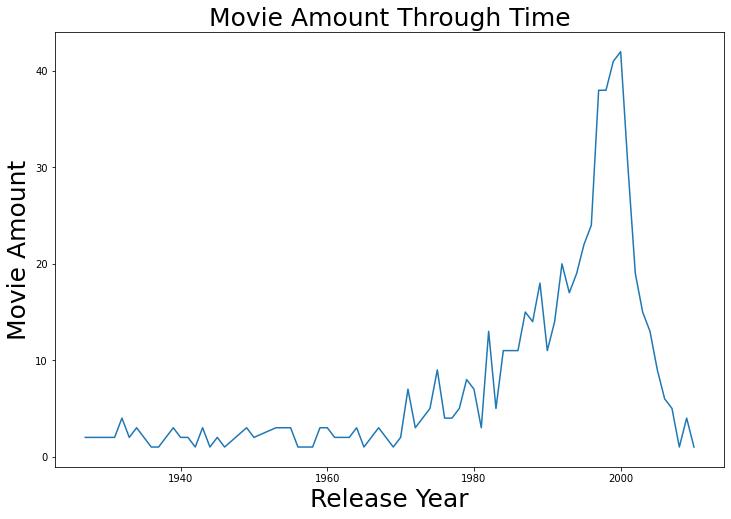

In [159]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(sorted(dict(info_df.year.value_counts())), [info_df.year.value_counts()[year] for year in sorted(dict(info_df.year.value_counts()))])
plt.xlabel('Release Year',fontsize=25)
plt.ylabel('Movie Amount',fontsize=25)
plt.title('Movie Amount Through Time', fontsize=25)
plt.savefig('/content/drive/MyDrive/IMDB/fig_results/summary_stats/movie_amount.png')

## Means & Median of Sentiments

### Mean

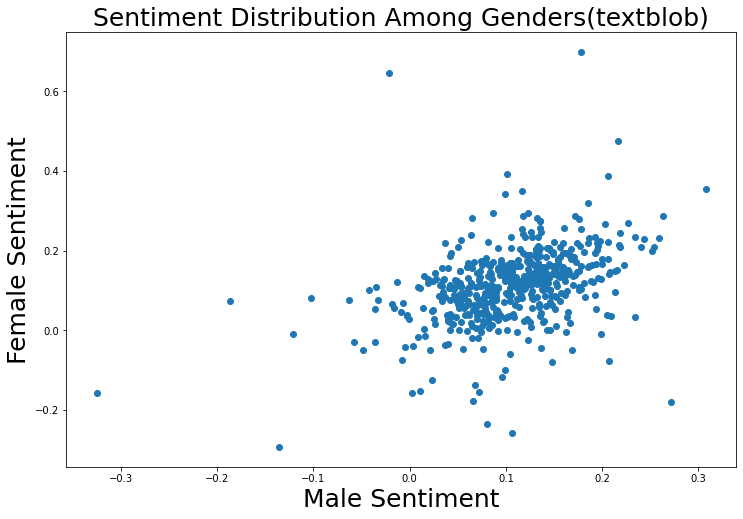

In [162]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(info_df['male_sent_blob'], info_df['female_sent_blob'])
plt.xlabel('Male Sentiment',fontsize=25)
plt.ylabel('Female Sentiment',fontsize=25)
plt.title('Sentiment Distribution Among Genders(textblob)', fontsize=25)
plt.savefig('/content/drive/MyDrive/IMDB/fig_results/means_gender/mean_blob.png')

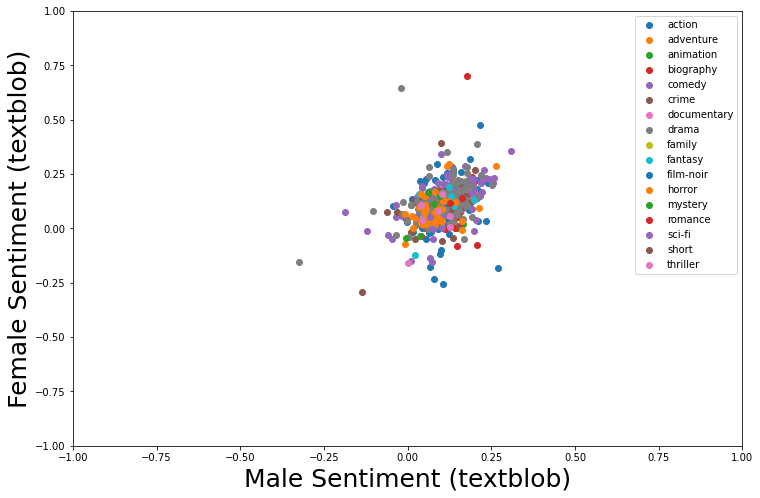

In [83]:
groups = info_df.groupby('genre')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.scatter(group.male_sent_blob, group.female_sent_blob, label=name)

plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.xlabel('Male Sentiment (textblob)',fontsize=25)
plt.ylabel('Female Sentiment (textblob)',fontsize=25)

plt.legend(loc = 'upper right')

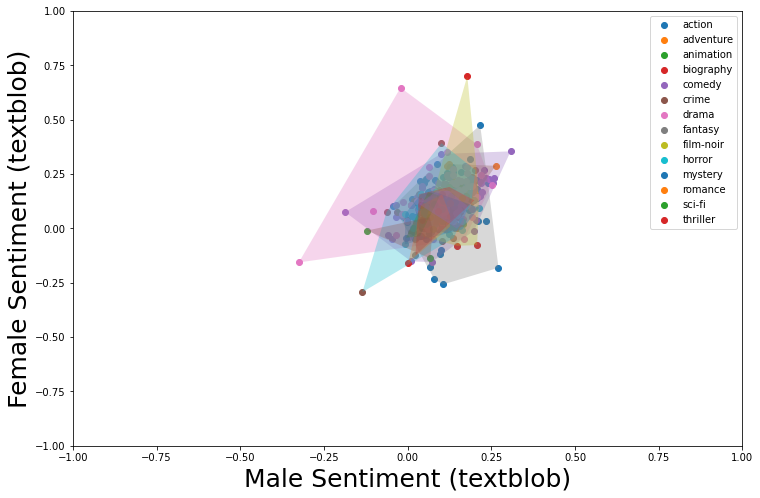

In [84]:
subdf = info_df[['male_sent_blob', 'female_sent_blob', 'genre']].dropna()
groups = subdf.groupby('genre')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.scatter(group.male_sent_blob, group.female_sent_blob, label=name)

# draw enclosure
for i in subdf.genre.unique():
    points = subdf[subdf.genre == i][['male_sent_blob', 'female_sent_blob']].values
    try:
      # get convex hull
      hull = ConvexHull(points)
      # get x and y coordinates
      # repeat last point to close the polygon
      x_hull = np.append(points[hull.vertices,0],
                        points[hull.vertices,0][0])
      y_hull = np.append(points[hull.vertices,1],
                        points[hull.vertices,1][0])
      # plot shape
      plt.fill(x_hull, y_hull, alpha=0.3)
    except:
      continue
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.xlabel('Male Sentiment (textblob)',fontsize=25)
plt.ylabel('Female Sentiment (textblob)',fontsize=25)

plt.legend(loc = 'upper right')

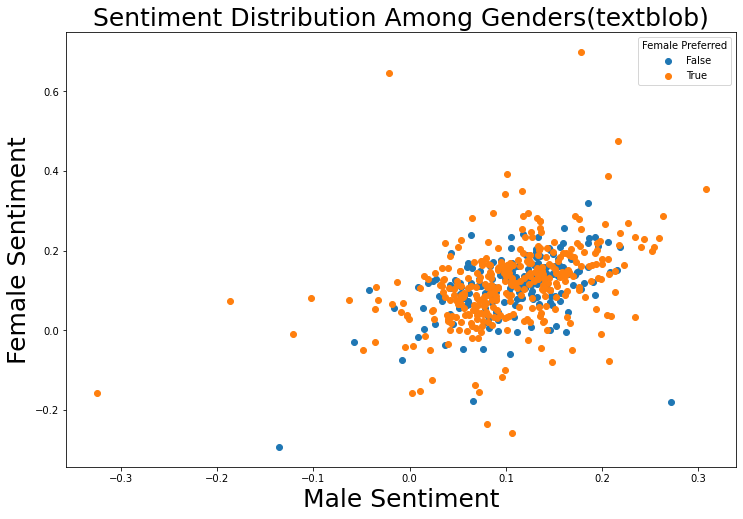

In [166]:
groups = info_df.groupby('female_prefer')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.scatter(group.male_sent_blob, group.female_sent_blob, label=name)

plt.xlabel('Male Sentiment',fontsize=25)
plt.ylabel('Female Sentiment',fontsize=25)
plt.title('Sentiment Distribution Among Genders(textblob)', fontsize=25)
plt.legend(loc = 'upper right', title="Female Preferred")
plt.savefig('/content/drive/MyDrive/IMDB/fig_results/means_gender/mean_blob_female_pref.png')

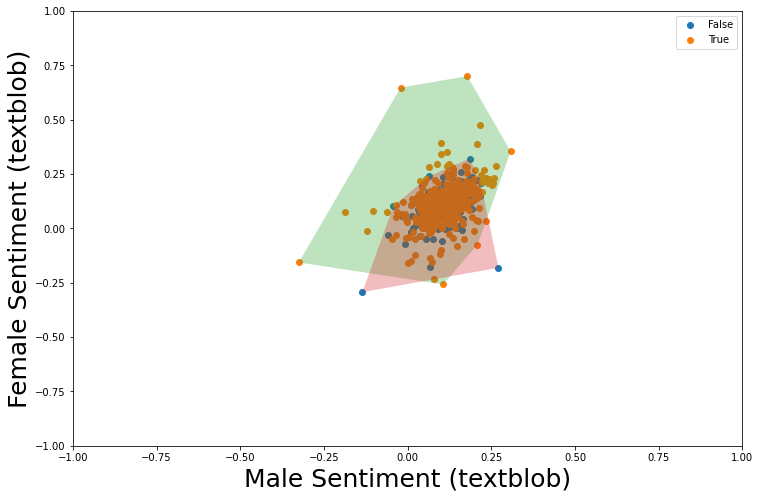

In [86]:
subdf = info_df[['male_sent_blob', 'female_sent_blob', 'female_prefer']].dropna()
groups = subdf.groupby('female_prefer')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.scatter(group.male_sent_blob, group.female_sent_blob, label=name)

# draw enclosure
for i in subdf.female_prefer.unique():
    points = subdf[subdf.female_prefer == i][['male_sent_blob', 'female_sent_blob']].values
    try:
      # get convex hull
      hull = ConvexHull(points)
      # get x and y coordinates
      # repeat last point to close the polygon
      x_hull = np.append(points[hull.vertices,0],
                        points[hull.vertices,0][0])
      y_hull = np.append(points[hull.vertices,1],
                        points[hull.vertices,1][0])
      # plot shape
      plt.fill(x_hull, y_hull, alpha=0.3)
    except:
      continue
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.xlabel('Male Sentiment (textblob)',fontsize=25)
plt.ylabel('Female Sentiment (textblob)',fontsize=25)

plt.legend(loc = 'upper right')

In [137]:
info_df['year_cat'] = info_df['year'].apply(lambda x: str(x)[:-1]+'0')

Text(0, 0.5, 'Female Sentiment (textblob)')

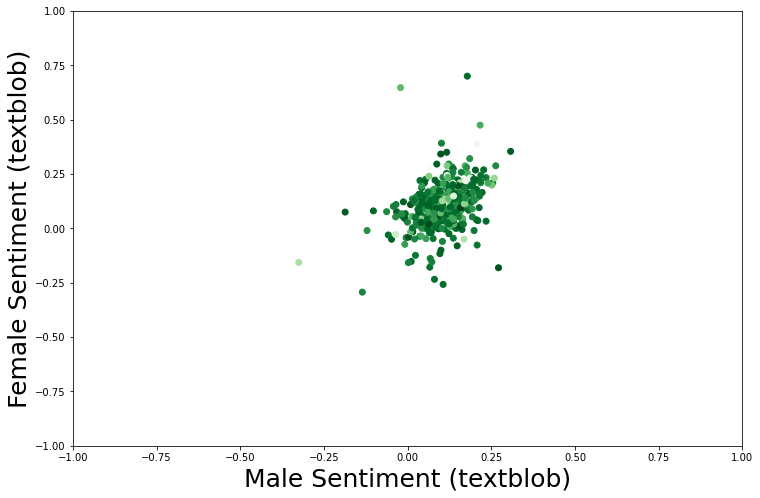

In [87]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(info_df['male_sent_blob'], info_df['female_sent_blob'], c=info_df['year'], cmap='Greens')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.xlabel('Male Sentiment (textblob)',fontsize=25)
plt.ylabel('Female Sentiment (textblob)',fontsize=25)

In [140]:
color_list = ['#e6e6ff', '#c7c7ff', '#a8a8ff', '#8a8aff', '#3d3dff', 
              '#2e2eff', '#0000f5', '#0000cc', '#0000a3', '#000066']

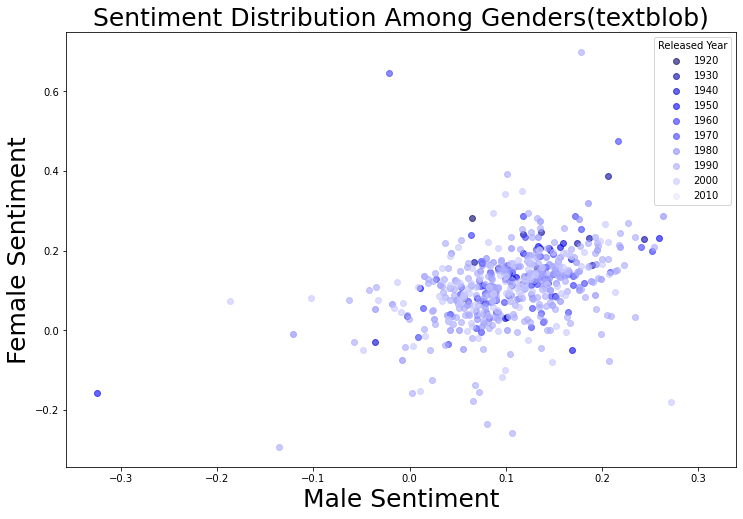

In [167]:
groups = info_df.groupby('year_cat')
fig, ax = plt.subplots(figsize=(12,8))
cnt = 0
for name, group in groups:
    ax.scatter(group.male_sent_blob, group.female_sent_blob, label=name, c=color_list[::-1][cnt], alpha = 0.6)
    cnt += 1

plt.xlabel('Male Sentiment',fontsize=25)
plt.ylabel('Female Sentiment',fontsize=25)
plt.title('Sentiment Distribution Among Genders(textblob)', fontsize=25)
plt.legend(loc = 'upper right', title="Released Year")
plt.savefig('/content/drive/MyDrive/IMDB/fig_results/means_gender/mean_blob_released_year.png')

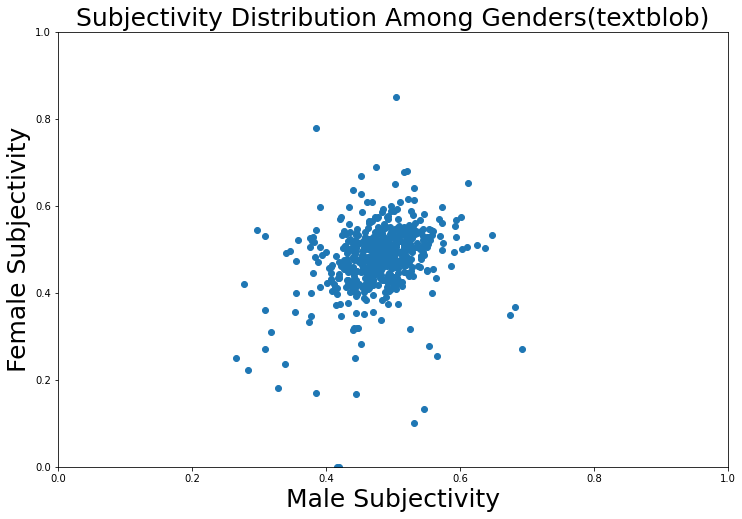

In [169]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(info_df['male_subj_blob'], info_df['female_subj_blob'])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Subjectivity',fontsize=25)
plt.ylabel('Female Subjectivity',fontsize=25)
plt.title('Subjectivity Distribution Among Genders(textblob)', fontsize=25)
plt.savefig('/content/drive/MyDrive/IMDB/fig_results/means_gender/mean_subj.png')

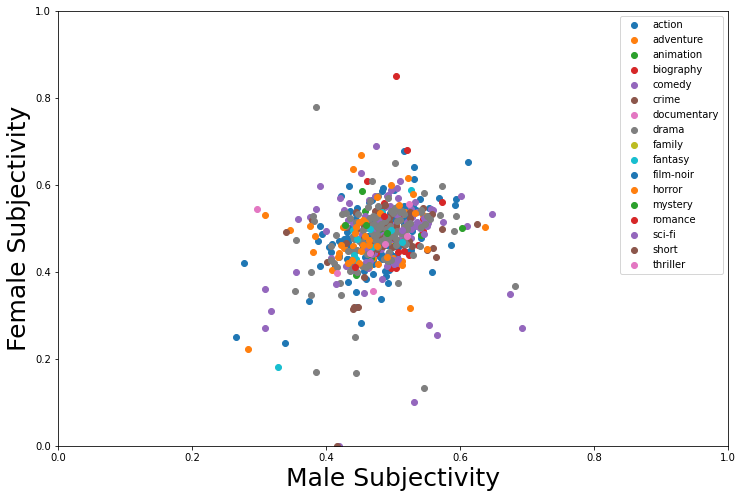

In [89]:
groups = info_df.groupby('genre')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.scatter(group.male_subj_blob, group.female_subj_blob, label=name)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Subjectivity',fontsize=25)
plt.ylabel('Female Subjectivity',fontsize=25)

plt.legend(loc = 'upper right')

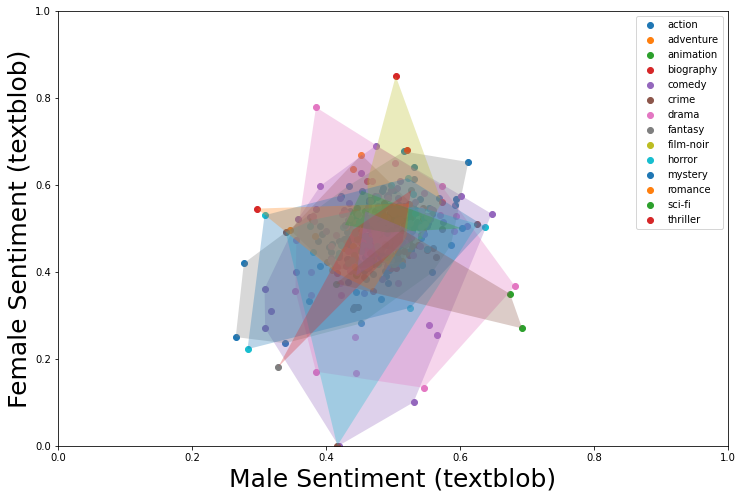

In [90]:
subdf = info_df[['male_subj_blob', 'female_subj_blob', 'genre']].dropna()
groups = subdf.groupby('genre')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.scatter(group.male_subj_blob, group.female_subj_blob, label=name)

# draw enclosure
for i in subdf.genre.unique():
    points = subdf[subdf.genre == i][['male_subj_blob', 'female_subj_blob']].values
    try:
      # get convex hull
      hull = ConvexHull(points)
      # get x and y coordinates
      # repeat last point to close the polygon
      x_hull = np.append(points[hull.vertices,0],
                        points[hull.vertices,0][0])
      y_hull = np.append(points[hull.vertices,1],
                        points[hull.vertices,1][0])
      # plot shape
      plt.fill(x_hull, y_hull, alpha=0.3)
    except:
      continue
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Sentiment (textblob)',fontsize=25)
plt.ylabel('Female Sentiment (textblob)',fontsize=25)

plt.legend(loc = 'upper right')

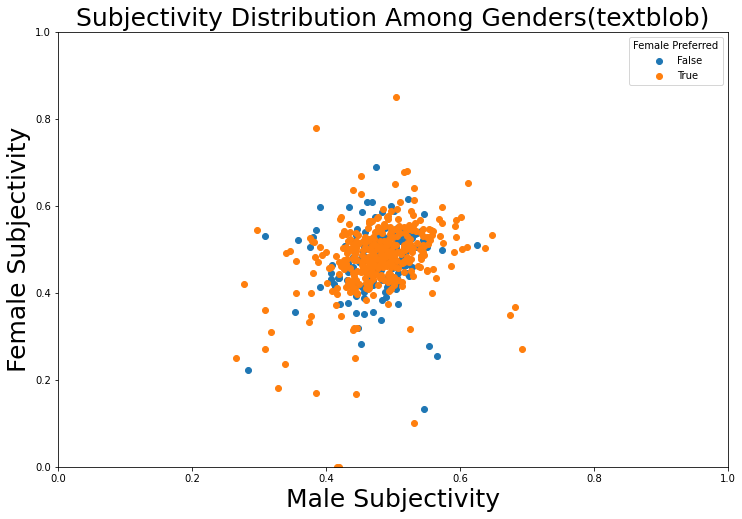

In [170]:
groups = info_df.groupby('female_prefer')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.scatter(group.male_subj_blob, group.female_subj_blob, label=name)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Subjectivity',fontsize=25)
plt.ylabel('Female Subjectivity',fontsize=25)
plt.legend(loc = 'upper right', title='Female Preferred')
plt.title('Subjectivity Distribution Among Genders(textblob)', fontsize=25)
plt.savefig('/content/drive/MyDrive/IMDB/fig_results/means_gender/mean_subj_female_pref.png')

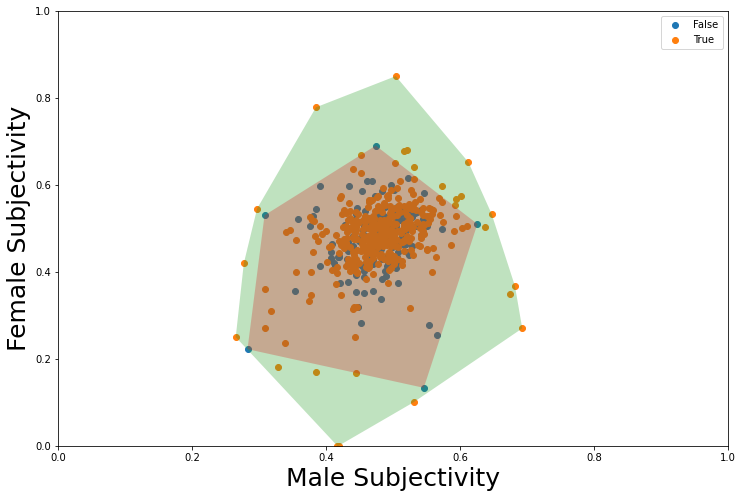

In [92]:
subdf = info_df[['male_subj_blob', 'female_subj_blob', 'female_prefer']].dropna()
groups = subdf.groupby('female_prefer')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.scatter(group.male_subj_blob, group.female_subj_blob, label=name)

# draw enclosure
for i in subdf.female_prefer.unique():
    points = subdf[subdf.female_prefer == i][['male_subj_blob', 'female_subj_blob']].values
    try:
      # get convex hull
      hull = ConvexHull(points)
      # get x and y coordinates
      # repeat last point to close the polygon
      x_hull = np.append(points[hull.vertices,0],
                        points[hull.vertices,0][0])
      y_hull = np.append(points[hull.vertices,1],
                        points[hull.vertices,1][0])
      # plot shape
      plt.fill(x_hull, y_hull, alpha=0.3)
    except:
      continue
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Subjectivity',fontsize=25)
plt.ylabel('Female Subjectivity',fontsize=25)

plt.legend(loc = 'upper right')

Text(0, 0.5, 'Female Subjectivity')

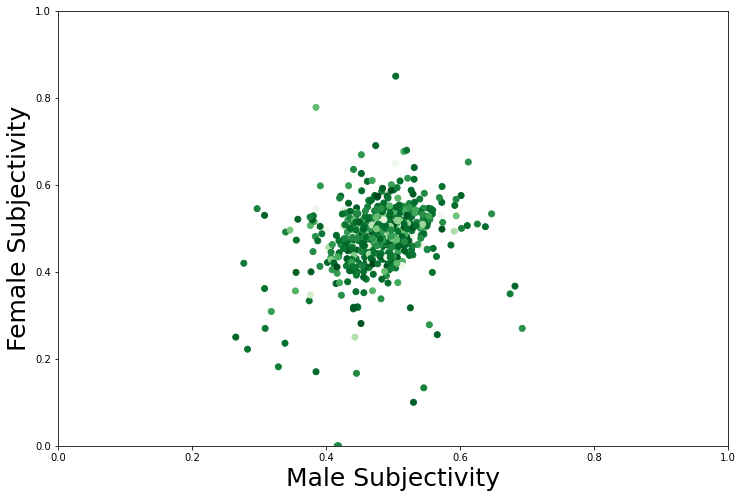

In [93]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(info_df['male_subj_blob'], info_df['female_subj_blob'], c=info_df['year'], cmap='Greens')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Subjectivity',fontsize=25)
plt.ylabel('Female Subjectivity',fontsize=25)

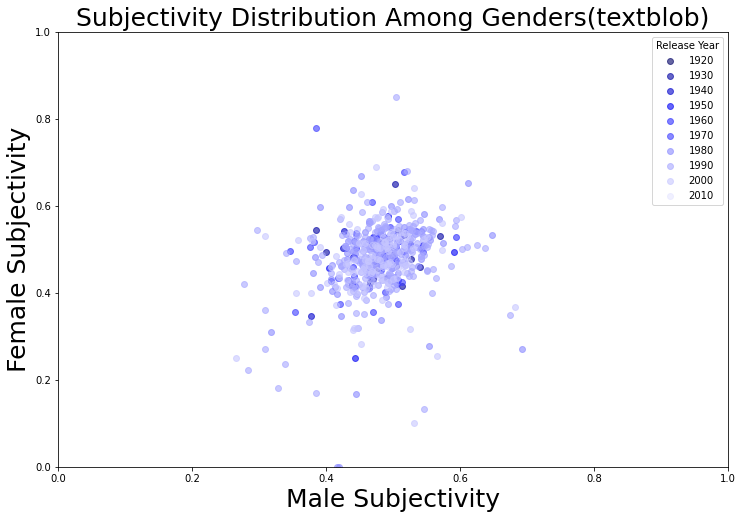

In [171]:
groups = info_df.sort_values(['year_cat'],ascending=False).groupby('year_cat')
fig, ax = plt.subplots(figsize=(12,8))
cnt = 0
for name, group in groups:
    ax.scatter(group.male_subj_blob, group.female_subj_blob, label=name, c=color_list[::-1][cnt], alpha = 0.6)
    cnt += 1

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Subjectivity',fontsize=25)
plt.ylabel('Female Subjectivity',fontsize=25)

plt.legend(loc = 'upper right', title='Release Year')
plt.title('Subjectivity Distribution Among Genders(textblob)', fontsize=25)
plt.savefig('/content/drive/MyDrive/IMDB/fig_results/means_gender/mean_subj_released_year.png')

In [152]:
info_df.sort_values(['year_cat'],ascending=False)

,index,IMDBid,Title_en,URL,year,Problem,poster_url,trailer_url,IMDB,MetaCritic,theMovieDb,RottenTomatoes,FilmAffinity,IMDB_male,IMDB_female,budget,openWeek,WorldGross,USCAGross,genre,male_sent_blob,male_subj_blob,male_sent_self,female_sent_blob,female_subj_blob,female_sent_self,md_male_sent_blob,md_male_subj_blob,md_male_sent_self,md_female_sent_blob,md_female_subj_blob,md_female_sent_self,std_male_sent_blob,std_male_subj_blob,std_male_sent_self,std_female_sent_blob,std_female_subj_blob,std_female_sent_self,female_prefer,year_cat
92,m181,tt1626229,simone,https://www.imdb.com/title/tt1626229/,2010,0.0,NaN,https://www.imdb.com/video/vi2312613913,6.9,NaN,NaN,NaN,NaN,6.0,10.0,1250.0,NaN,NaN,NaN,short,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2010
94,m183,tt0301848,slash,https://www.imdb.com/title/tt0301848/?ref_=fn_...,2002,0.0,https://imdb-api.com/posters/original/wD5FkAFr...,https://www.imdb.com/video/vi3012034841,4.3,NaN,4.4,NaN,3.6,4.2,4.4,NaN,NaN,NaN,NaN,comedy,-0.047980,0.530808,0.661953,-0.050000,0.100000,0.332523,0.000000,0.466667,0.985343,-0.050000,0.100000,0.332523,0.136051,0.159374,0.465058,0.000000,0.000000,0.000000,True,2000
121,m207,tt0268995,the majestic,https://www.imdb.com/title/tt0268995/?ref_=fn_...,2001,0.0,https://imdb-api.com/posters/original/mRO7mC66...,https://www.imdb.com/video/vi2431648025,6.9,27.0,6.8,42.0,6.2,6.9,6.9,72000000.0,4904339.0,37317673.0,27807266.0,drama,0.100677,0.445727,0.768583,0.136231,0.450297,0.799782,0.087358,0.425500,0.968706,0.111667,0.465000,0.971611,0.200344,0.187103,0.353724,0.156576,0.194027,0.293394,True,2000
113,m20,tt0144084,american psycho,https://www.imdb.com/title/tt0144084/?ref_=fn_...,2000,0.0,https://imdb-api.com/posters/original/3ddHhfMl...,https://www.imdb.com/video/vi4060743449,7.6,64.0,7.4,69.0,6.6,7.6,7.5,7000000.0,4961015.0,34266564.0,15070285.0,drama,0.113780,0.513773,0.712368,0.097242,0.538988,0.624125,0.100000,0.520000,0.985789,0.098810,0.550868,0.915271,0.229519,0.205950,0.403553,0.244825,0.233106,0.415523,False,2000
484,m534,tt0250081,storytelling,https://www.imdb.com/title/tt0250081/?ref_=fn_...,2001,0.0,https://imdb-api.com/posters/original/5hSpaT8x...,https://www.imdb.com/video/vi3196780825,6.8,50.0,6.6,53.0,6.7,6.8,6.7,NaN,73688.0,1318945.0,921445.0,comedy,0.119595,0.474343,0.809337,0.119028,0.690278,0.701195,0.029226,0.561270,0.977545,0.000000,0.566667,0.989527,0.155848,0.216679,0.360584,0.184772,0.220488,0.413861,False,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,m484,tt0023649,vampyr,https://www.imdb.com/title/tt0023649/?ref_=fn_...,1932,0.0,https://imdb-api.com/posters/original/yt3JS5JS...,https://www.imdb.com/video/vi4103914265,7.4,NaN,7.5,97.0,7.4,7.4,7.4,NaN,NaN,NaN,NaN,fantasy,NaN,NaN,NaN,0.129630,0.488889,0.991054,NaN,NaN,NaN,0.129630,0.488889,0.991054,NaN,NaN,NaN,0.000000,0.000000,0.000000,True,1930
468,m52,tt0023969,duck soup,https://www.imdb.com/title/tt0023969/?ref_=fn_...,1933,0.0,https://imdb-api.com/posters/original/7ZJKzr5U...,https://www.imdb.com/video/vi2848505625,7.8,93.0,7.4,91.0,8.1,7.8,7.7,NaN,NaN,103800.0,NaN,comedy,0.117907,0.483678,0.750357,0.243112,0.515265,0.869461,0.150000,0.466032,0.985718,0.250000,0.500000,0.984931,0.281325,0.244640,0.346288,0.354158,0.227049,0.264114,False,1930
593,m78,tt0022958,grand hotel,https://www.imdb.com/title/tt0022958/?ref_=fn_...,1932,0.0,https://imdb-api.com/posters/original/2j7dxqIl...,https://www.imdb.com/video/vi3953263897,7.3,NaN,7.0,86.0,7.1,7.3,7.5,700000.0,NaN,NaN,NaN,drama,0.173581,0.570967,0.950153,0.218857,0.530476,0.784054,0.193958,0.558056,0.989351,0.212500,0.526515,0.988948,0.199176,0.117219,0.102376,0.158950,0.159391,0.338028,True,1930
342,m406,tt0018037,the jazz singer,https://www.imdb.com/title/tt0018037/?ref_=fn_...,1927,0.0,https://imdb-api.com/posters/original/lEvDchgQ...,NaN,6.4,66.0,6.3,78.0,6.2,6.4,6.5,422000.0,NaN,

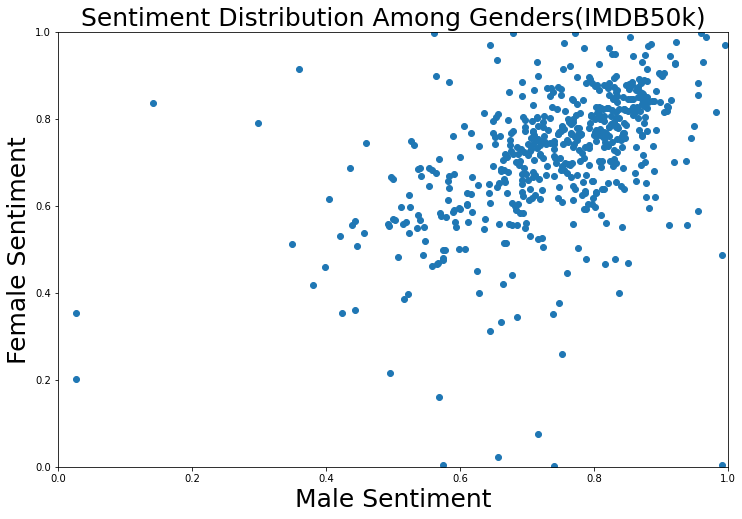

In [177]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(info_df['male_sent_self'], info_df['female_sent_self'])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Sentiment',fontsize=25)
plt.ylabel('Female Sentiment',fontsize=25)
plt.title('Sentiment Distribution Among Genders(IMDB50k)', fontsize=25)
plt.savefig('/content/drive/MyDrive/IMDB/fig_results/means_gender/mean_self.png')

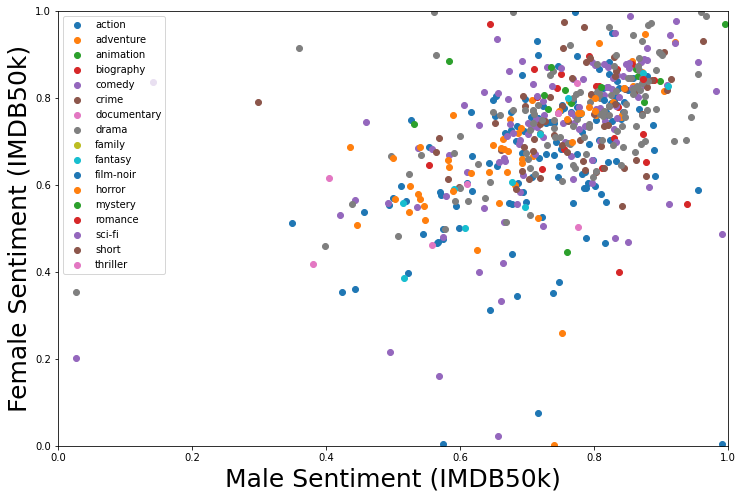

In [95]:
groups = info_df.groupby('genre')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.scatter(group.male_sent_self, group.female_sent_self, label=name)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Sentiment (IMDB50k)',fontsize=25)
plt.ylabel('Female Sentiment (IMDB50k)',fontsize=25)

plt.legend(loc = 'upper left')

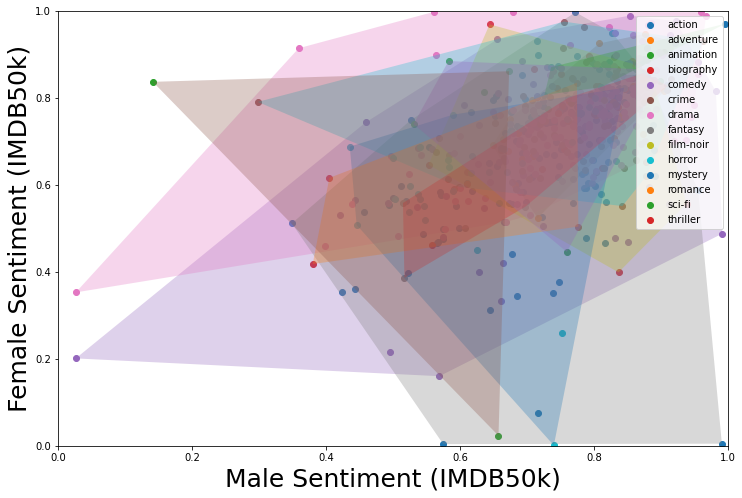

In [96]:
subdf = info_df[['male_sent_self', 'female_sent_self', 'genre']].dropna()
groups = subdf.groupby('genre')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.scatter(group.male_sent_self, group.female_sent_self, label=name)

# draw enclosure
for i in subdf.genre.unique():
    points = subdf[subdf.genre == i][['male_sent_self', 'female_sent_self']].values
    try:
      # get convex hull
      hull = ConvexHull(points)
      # get x and y coordinates
      # repeat last point to close the polygon
      x_hull = np.append(points[hull.vertices,0],
                        points[hull.vertices,0][0])
      y_hull = np.append(points[hull.vertices,1],
                        points[hull.vertices,1][0])
      # plot shape
      plt.fill(x_hull, y_hull, alpha=0.3)
    except:
      continue
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Sentiment (IMDB50k)',fontsize=25)
plt.ylabel('Female Sentiment (IMDB50k)',fontsize=25)

plt.legend(loc = 'upper right')

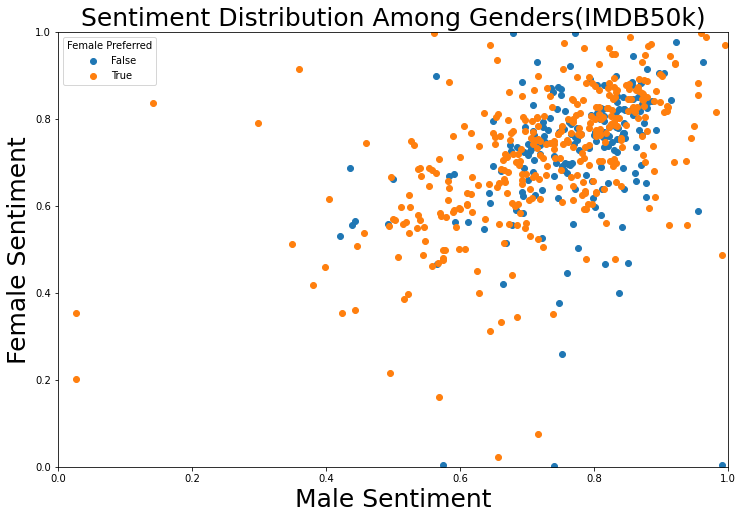

In [176]:
groups = info_df.groupby('female_prefer')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.scatter(group.male_sent_self, group.female_sent_self, label=name)

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.legend(loc = 'upper left', title='Female Preferred')
plt.xlabel('Male Sentiment',fontsize=25)
plt.ylabel('Female Sentiment',fontsize=25)
plt.title('Sentiment Distribution Among Genders(IMDB50k)', fontsize=25)
plt.savefig('/content/drive/MyDrive/IMDB/fig_results/means_gender/mean_self_female_pref.png')

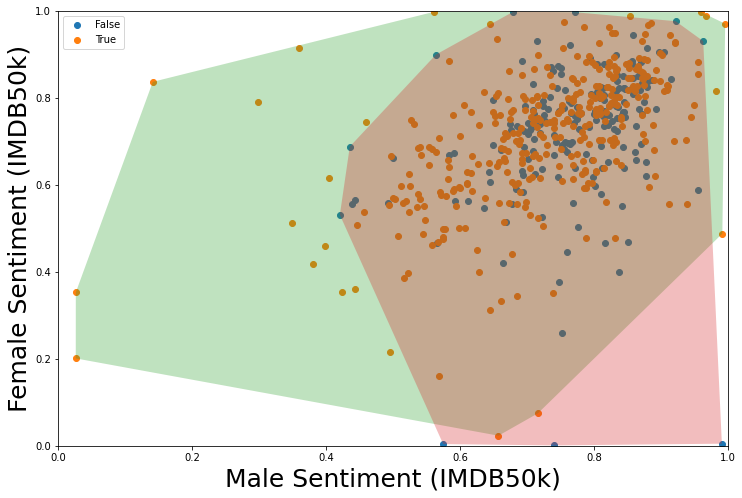

In [98]:
subdf = info_df[['male_sent_self', 'female_sent_self', 'female_prefer']].dropna()

groups = info_df.groupby('female_prefer')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.scatter(group.male_sent_self, group.female_sent_self, label=name)

# draw enclosure
for i in subdf.female_prefer.unique():
    points = subdf[subdf.female_prefer == i][['male_sent_self', 'female_sent_self']].values
    try:
      # get convex hull
      hull = ConvexHull(points)
      # get x and y coordinates
      # repeat last point to close the polygon
      x_hull = np.append(points[hull.vertices,0],
                        points[hull.vertices,0][0])
      y_hull = np.append(points[hull.vertices,1],
                        points[hull.vertices,1][0])
      # plot shape
      plt.fill(x_hull, y_hull, alpha=0.3)
    except:
      continue

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Sentiment (IMDB50k)',fontsize=25)
plt.ylabel('Female Sentiment (IMDB50k)',fontsize=25)

plt.legend(loc = 'upper left')

Text(0, 0.5, 'Female Sentiment (IMDB50k)')

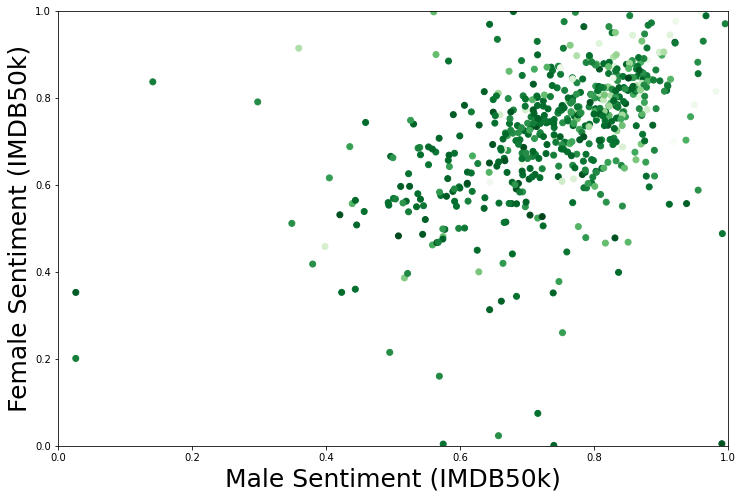

In [99]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(info_df['male_sent_self'], info_df['female_sent_self'], c=info_df['year'], cmap='Greens')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Sentiment (IMDB50k)',fontsize=25)
plt.ylabel('Female Sentiment (IMDB50k)',fontsize=25)

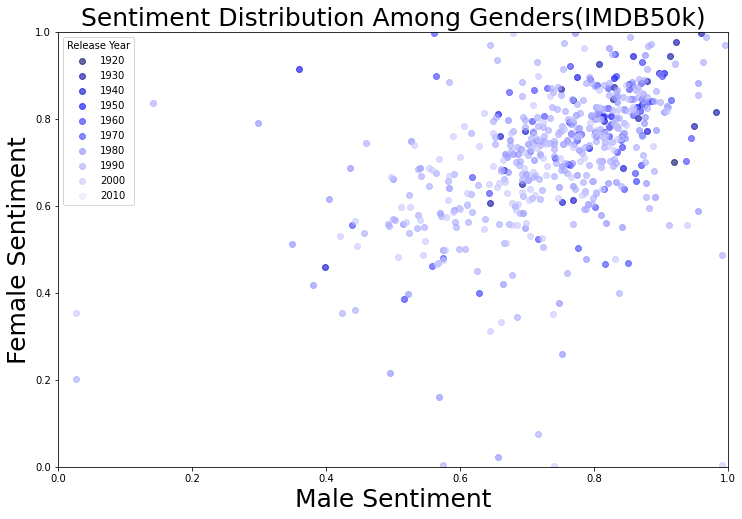

In [175]:
groups = info_df.sort_values(['year_cat'],ascending=False).groupby('year_cat')
fig, ax = plt.subplots(figsize=(12,8))
cnt = 0
for name, group in groups:
    ax.scatter(group.male_sent_self, group.female_sent_self, label=name, c=color_list[::-1][cnt], alpha = 0.6)
    cnt += 1

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc = 'upper left', title='Release Year')
plt.xlabel('Male Sentiment',fontsize=25)
plt.ylabel('Female Sentiment',fontsize=25)
plt.title('Sentiment Distribution Among Genders(IMDB50k)', fontsize=25)
plt.savefig('/content/drive/MyDrive/IMDB/fig_results/means_gender/mean_self_released_year.png')

### Median

Text(0, 0.5, 'Female Sentiment (textblob)')

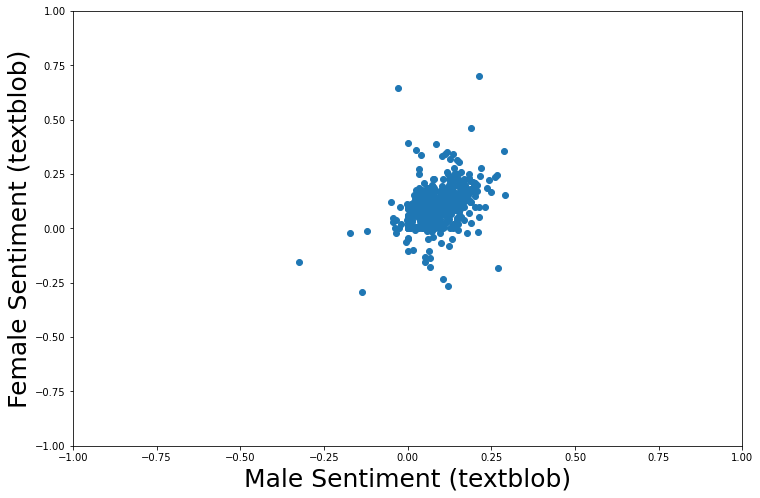

In [124]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(info_df['md_male_sent_blob'], info_df['md_female_sent_blob'])
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.xlabel('Male Sentiment (textblob)',fontsize=25)
plt.ylabel('Female Sentiment (textblob)',fontsize=25)

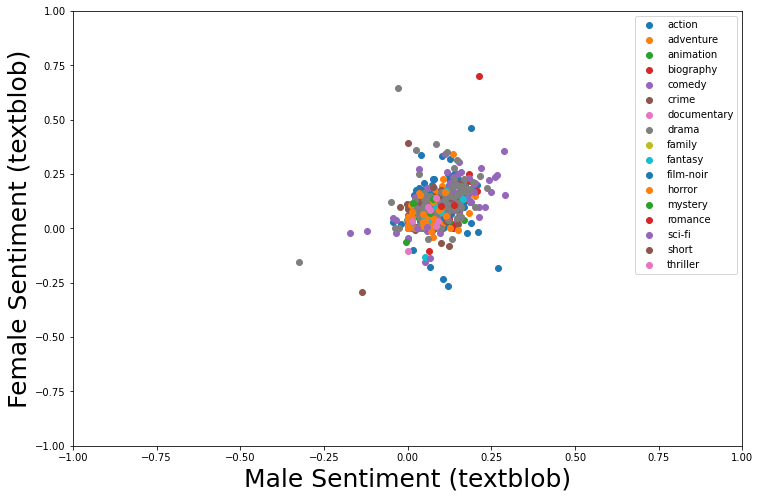

In [125]:
groups = info_df.groupby('genre')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.scatter(group.md_male_sent_blob, group.md_female_sent_blob, label=name)

plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.xlabel('Male Sentiment (textblob)',fontsize=25)
plt.ylabel('Female Sentiment (textblob)',fontsize=25)

plt.legend(loc = 'upper right')

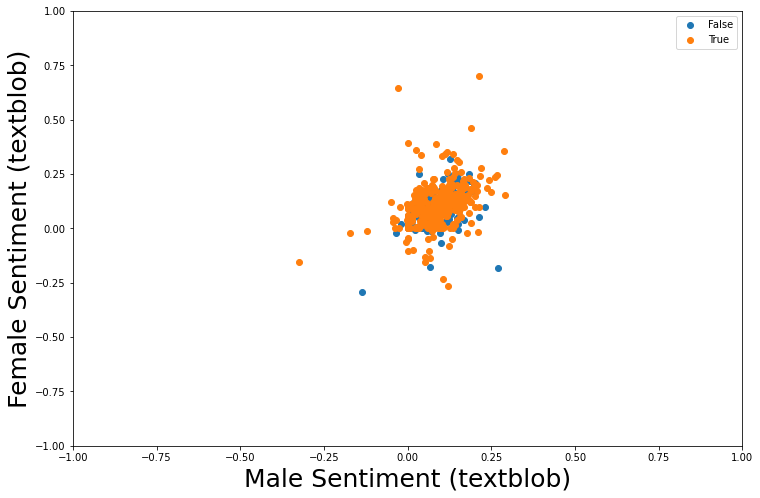

In [126]:
groups = info_df.groupby('female_prefer')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.scatter(group.md_male_sent_blob, group.md_female_sent_blob, label=name)

plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.xlabel('Male Sentiment (textblob)',fontsize=25)
plt.ylabel('Female Sentiment (textblob)',fontsize=25)

plt.legend(loc = 'upper right')

Text(0, 0.5, 'Female Sentiment (textblob)')

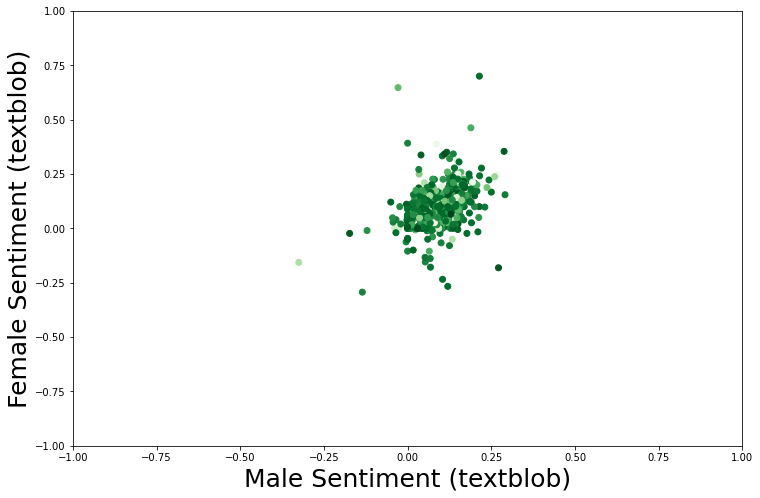

In [127]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(info_df['md_male_sent_blob'], info_df['md_female_sent_blob'], c=info_df['year'], cmap='Greens')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.xlabel('Male Sentiment (textblob)',fontsize=25)
plt.ylabel('Female Sentiment (textblob)',fontsize=25)

Text(0, 0.5, 'Female Subjectivity')

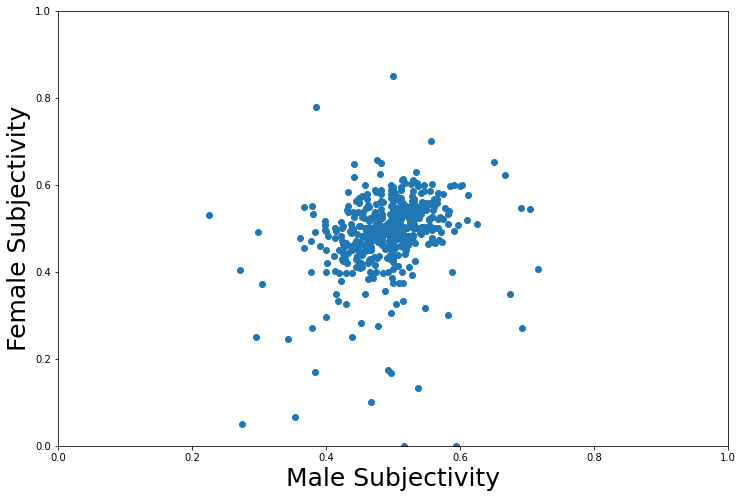

In [128]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(info_df['md_male_subj_blob'], info_df['md_female_subj_blob'])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Subjectivity',fontsize=25)
plt.ylabel('Female Subjectivity',fontsize=25)

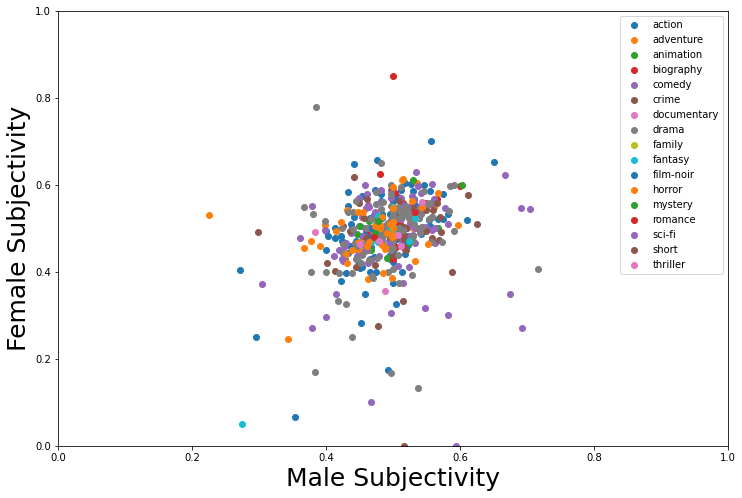

In [129]:
groups = info_df.groupby('genre')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.scatter(group.md_male_subj_blob, group.md_female_subj_blob, label=name)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Subjectivity',fontsize=25)
plt.ylabel('Female Subjectivity',fontsize=25)

plt.legend(loc = 'upper right')

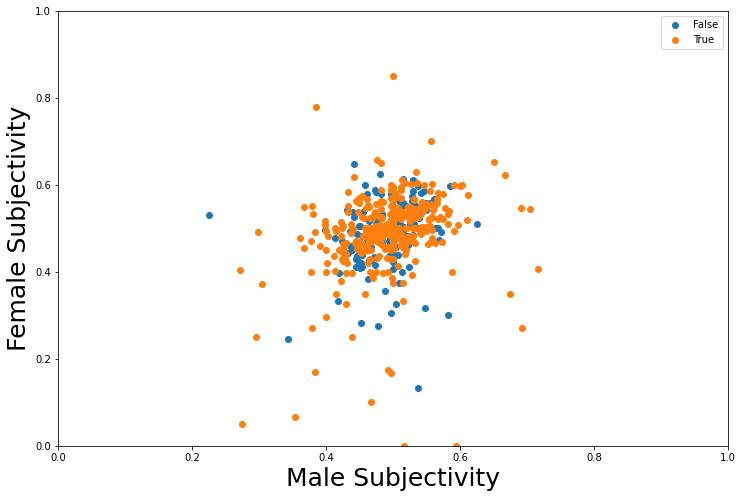

In [130]:
groups = info_df.groupby('female_prefer')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.scatter(group.md_male_subj_blob, group.md_female_subj_blob, label=name)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Subjectivity',fontsize=25)
plt.ylabel('Female Subjectivity',fontsize=25)

plt.legend(loc = 'upper right')

Text(0, 0.5, 'Female Subjectivity')

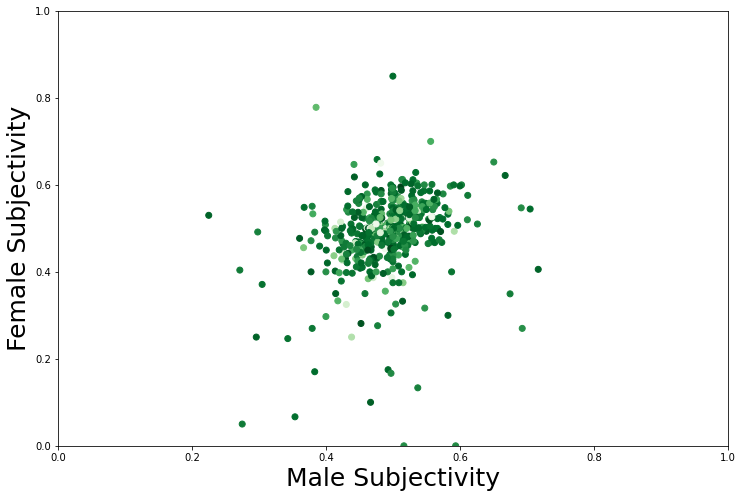

In [131]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(info_df['md_male_subj_blob'], info_df['md_female_subj_blob'], c=info_df['year'], cmap='Greens')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Subjectivity',fontsize=25)
plt.ylabel('Female Subjectivity',fontsize=25)

Text(0, 0.5, 'Female Sentiment (IMDB50k)')

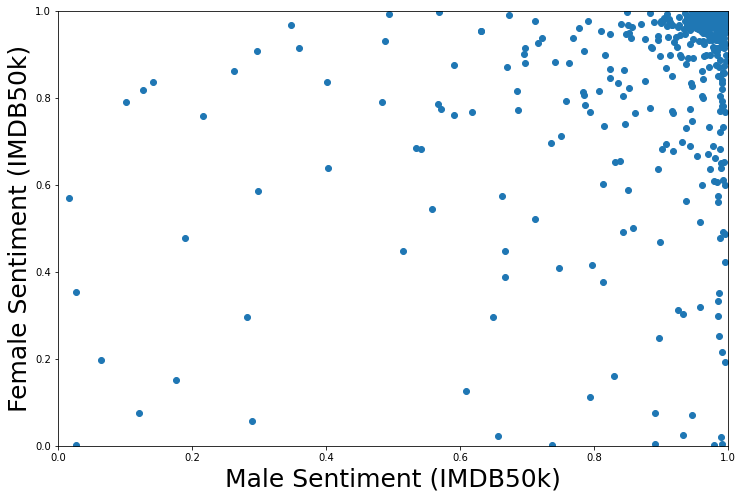

In [132]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(info_df['md_male_sent_self'], info_df['md_female_sent_self'])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Sentiment (IMDB50k)',fontsize=25)
plt.ylabel('Female Sentiment (IMDB50k)',fontsize=25)

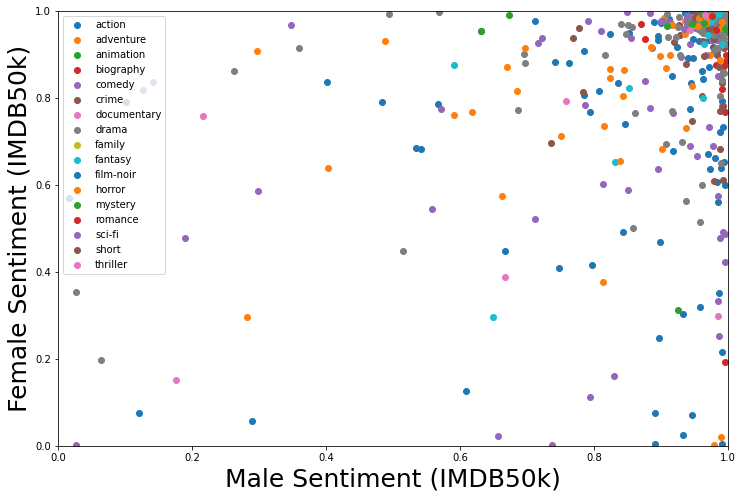

In [133]:
groups = info_df.groupby('genre')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.scatter(group.md_male_sent_self, group.md_female_sent_self, label=name)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Sentiment (IMDB50k)',fontsize=25)
plt.ylabel('Female Sentiment (IMDB50k)',fontsize=25)

plt.legend(loc = 'upper left')

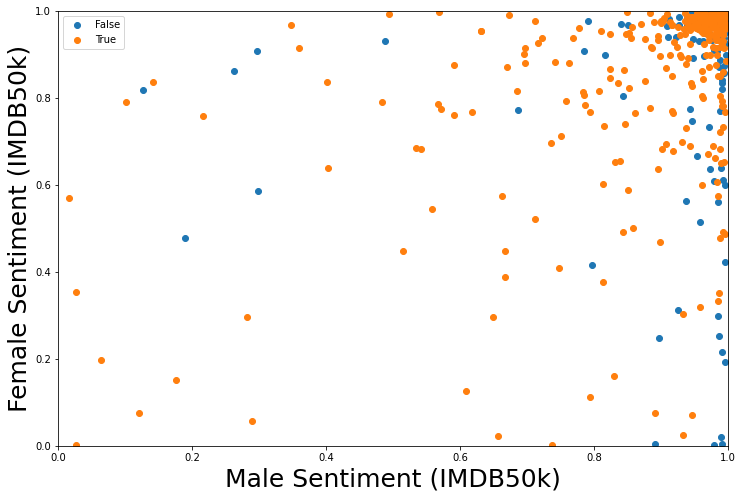

In [134]:
groups = info_df.groupby('female_prefer')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.scatter(group.md_male_sent_self, group.md_female_sent_self, label=name)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Sentiment (IMDB50k)',fontsize=25)
plt.ylabel('Female Sentiment (IMDB50k)',fontsize=25)

plt.legend(loc = 'upper left')

Text(0, 0.5, 'Female Sentiment (IMDB50k)')

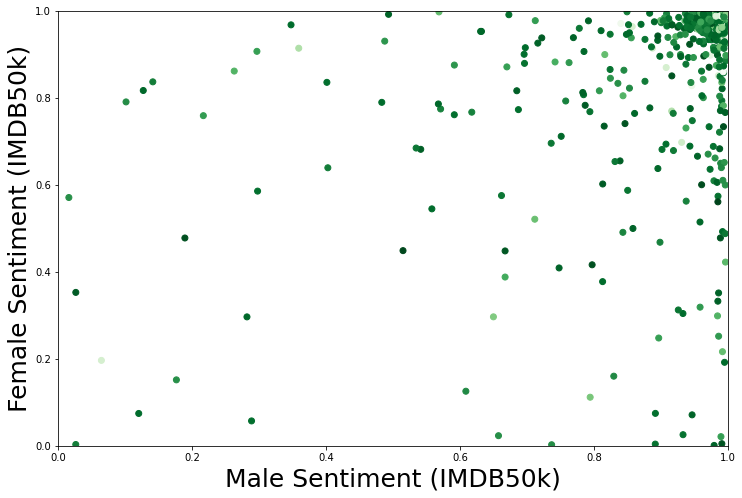

In [135]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(info_df['md_male_sent_self'], info_df['md_female_sent_self'], c=info_df['year'], cmap='Greens')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Sentiment (IMDB50k)',fontsize=25)
plt.ylabel('Female Sentiment (IMDB50k)',fontsize=25)

### Standard Deviation

Text(0, 0.5, 'Female Sentiment (textblob)')

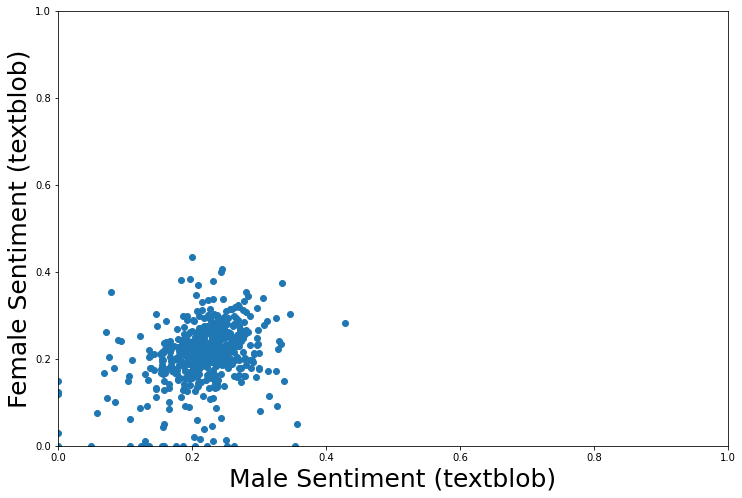

In [112]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(info_df['std_male_sent_blob'], info_df['std_female_sent_blob'])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Sentiment (textblob)',fontsize=25)
plt.ylabel('Female Sentiment (textblob)',fontsize=25)

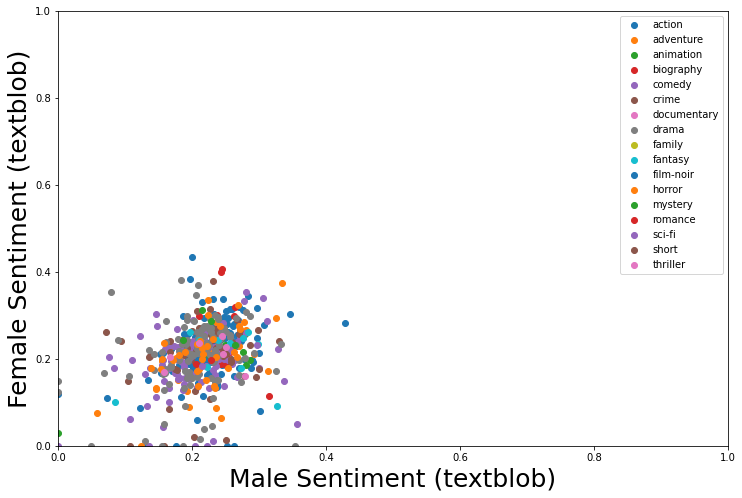

In [113]:
groups = info_df.groupby('genre')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.scatter(group.std_male_sent_blob, group.std_female_sent_blob, label=name)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Sentiment (textblob)',fontsize=25)
plt.ylabel('Female Sentiment (textblob)',fontsize=25)

plt.legend(loc = 'upper right')

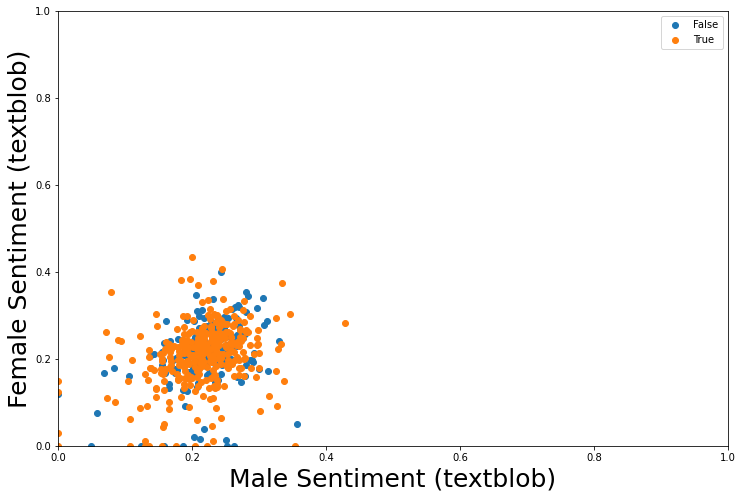

In [114]:
groups = info_df.groupby('female_prefer')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.scatter(group.std_male_sent_blob, group.std_female_sent_blob, label=name)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Sentiment (textblob)',fontsize=25)
plt.ylabel('Female Sentiment (textblob)',fontsize=25)

plt.legend(loc = 'upper right')

Text(0, 0.5, 'Female Sentiment (textblob)')

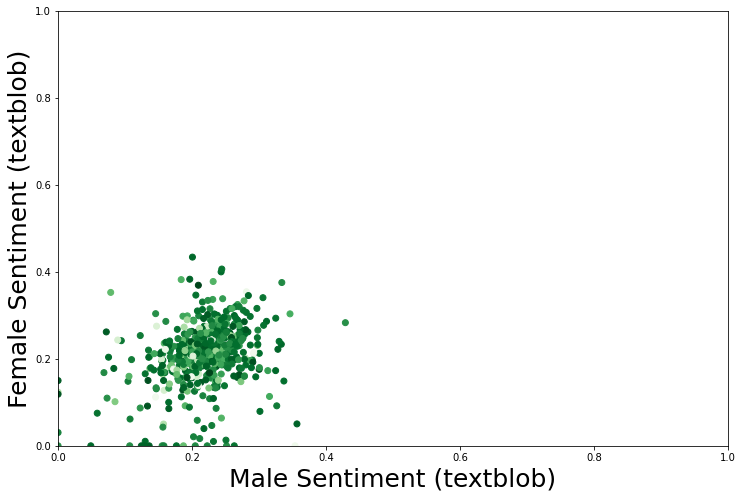

In [115]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(info_df['std_male_sent_blob'], info_df['std_female_sent_blob'], c=info_df['year'], cmap='Greens')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Sentiment (textblob)',fontsize=25)
plt.ylabel('Female Sentiment (textblob)',fontsize=25)

Text(0, 0.5, 'Female Subjectivity')

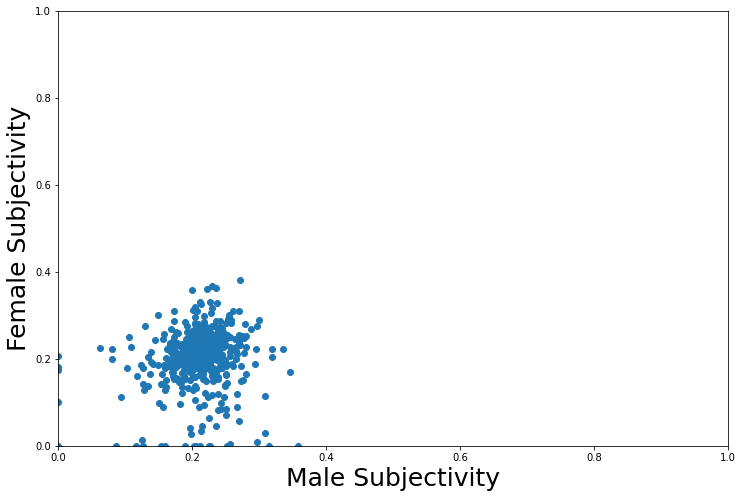

In [116]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(info_df['std_male_subj_blob'], info_df['std_female_subj_blob'])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Subjectivity',fontsize=25)
plt.ylabel('Female Subjectivity',fontsize=25)

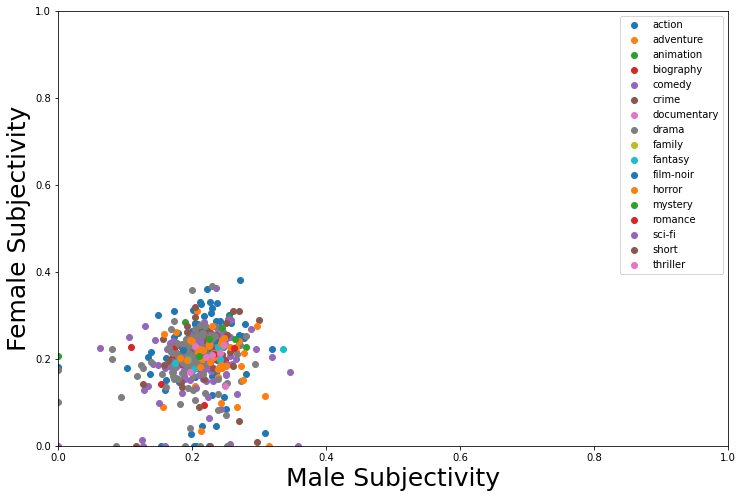

In [117]:
groups = info_df.groupby('genre')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.scatter(group.std_male_subj_blob, group.std_female_subj_blob, label=name)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Subjectivity',fontsize=25)
plt.ylabel('Female Subjectivity',fontsize=25)

plt.legend(loc = 'upper right')

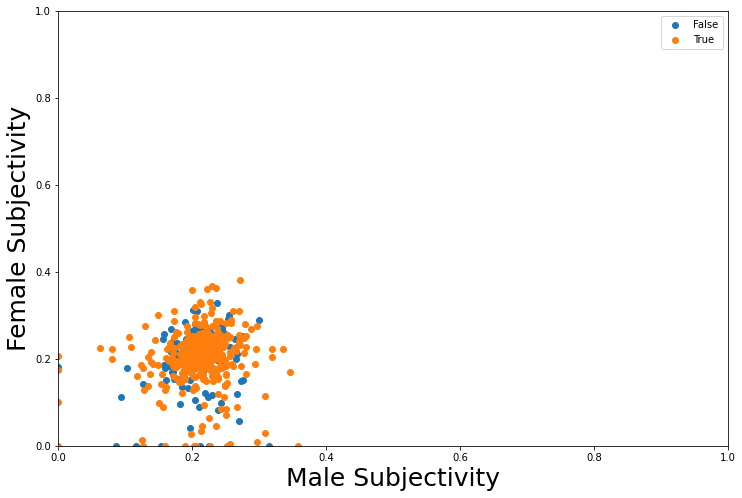

In [118]:
groups = info_df.groupby('female_prefer')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.scatter(group.std_male_subj_blob, group.std_female_subj_blob, label=name)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Subjectivity',fontsize=25)
plt.ylabel('Female Subjectivity',fontsize=25)

plt.legend(loc = 'upper right')

Text(0, 0.5, 'Female Subjectivity')

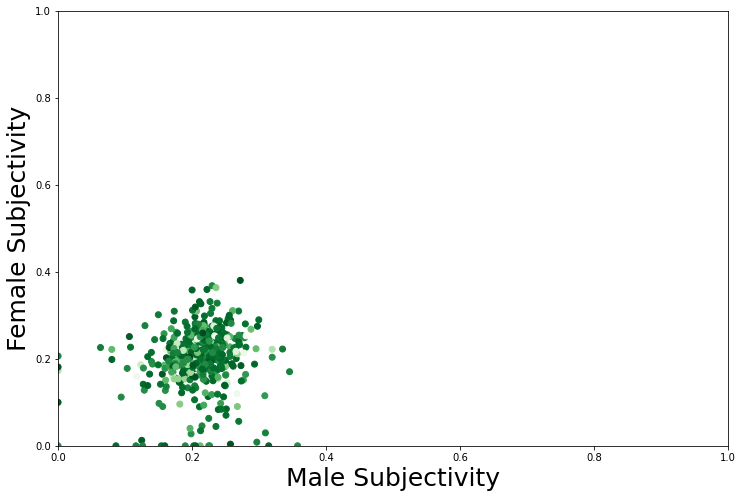

In [119]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(info_df['std_male_subj_blob'], info_df['std_female_subj_blob'], c=info_df['year'], cmap='Greens')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Subjectivity',fontsize=25)
plt.ylabel('Female Subjectivity',fontsize=25)

Text(0, 0.5, 'Female Sentiment (IMDB50k)')

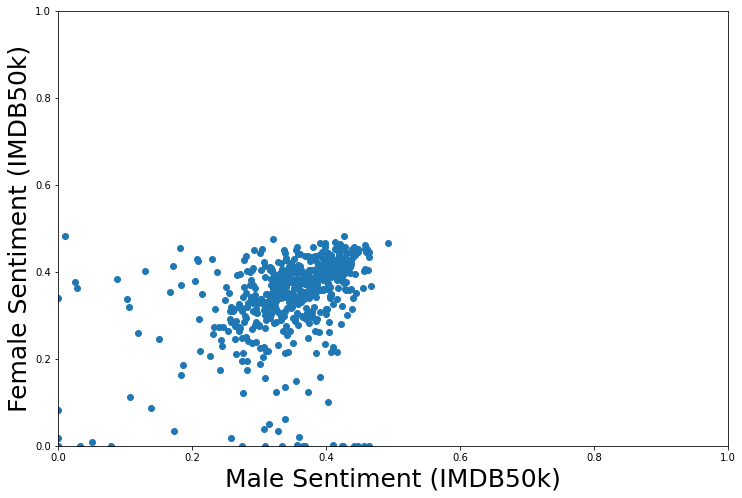

In [120]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(info_df['std_male_sent_self'], info_df['std_female_sent_self'])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Sentiment (IMDB50k)',fontsize=25)
plt.ylabel('Female Sentiment (IMDB50k)',fontsize=25)

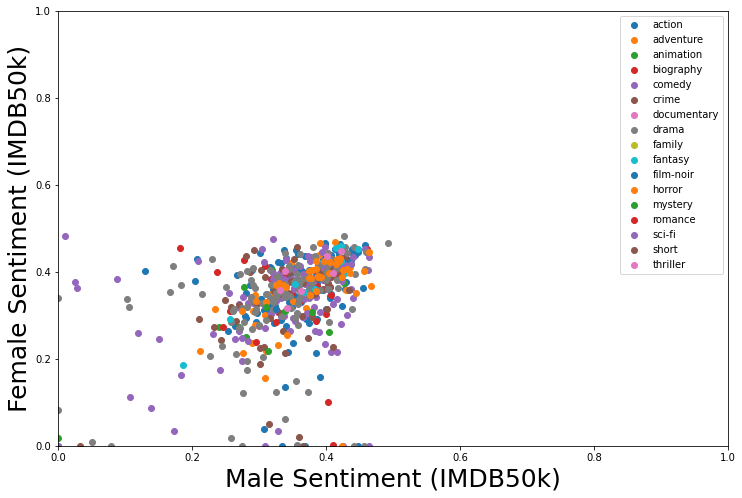

In [121]:
groups = info_df.groupby('genre')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.scatter(group.std_male_sent_self, group.std_female_sent_self, label=name)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Sentiment (IMDB50k)',fontsize=25)
plt.ylabel('Female Sentiment (IMDB50k)',fontsize=25)

plt.legend(loc = 'upper right')

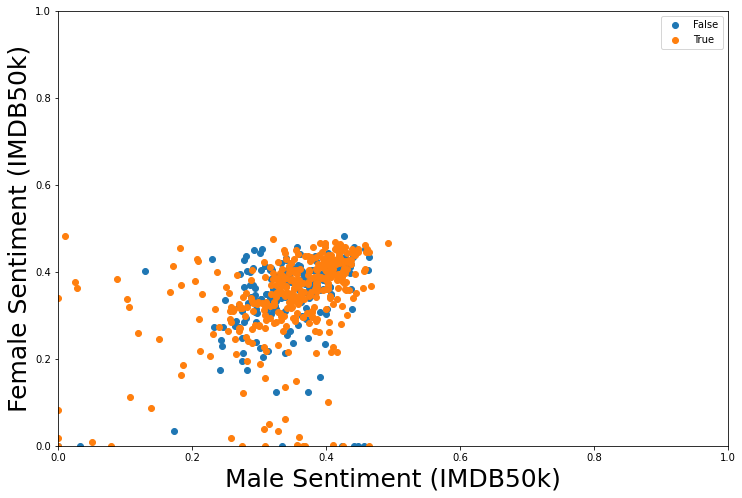

In [122]:
groups = info_df.groupby('female_prefer')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.scatter(group.std_male_sent_self, group.std_female_sent_self, label=name)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Sentiment (IMDB50k)',fontsize=25)
plt.ylabel('Female Sentiment (IMDB50k)',fontsize=25)

plt.legend(loc = 'upper right')

Text(0, 0.5, 'Female Sentiment (IMDB50k)')

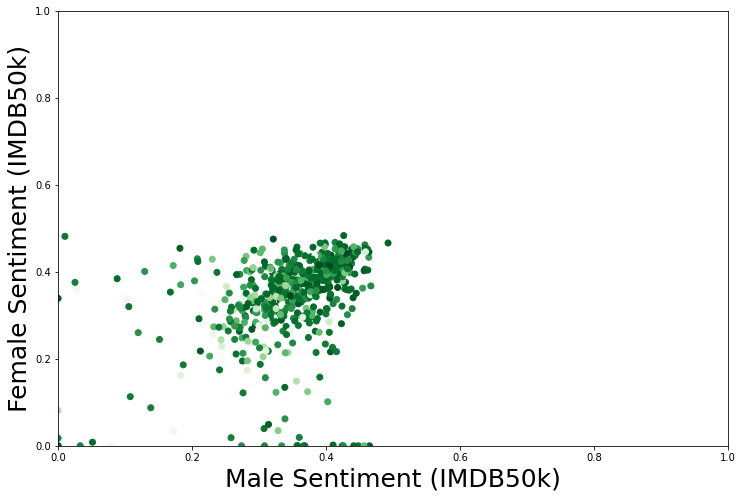

In [123]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(info_df['std_male_sent_self'], info_df['std_female_sent_self'], c=info_df['year'], cmap='Greens')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Male Sentiment (IMDB50k)',fontsize=25)
plt.ylabel('Female Sentiment (IMDB50k)',fontsize=25)

## Use (mean, variance) as Sample Point

### Sentiment textblob

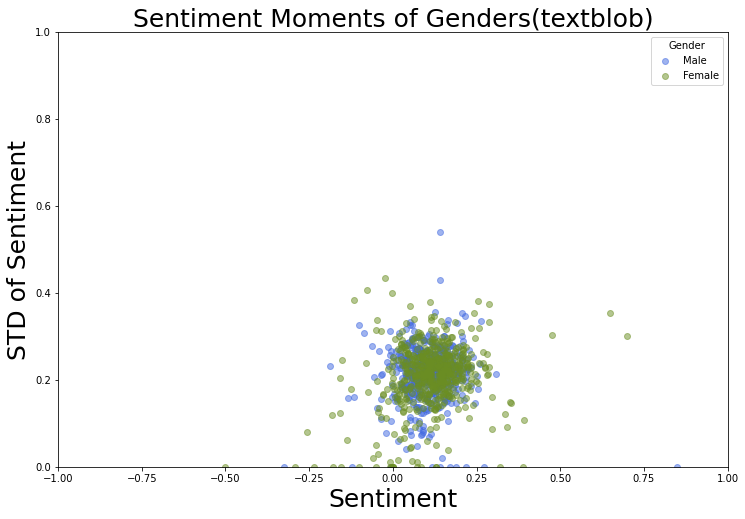

In [184]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(info_df['male_sent_blob'], info_df['std_male_sent_blob'], c='royalblue', label='Male', alpha=0.5)
ax.scatter(info_df['female_sent_blob'], info_df['std_female_sent_blob'], c='olivedrab', label='Female', alpha=0.5)
plt.xlim([-1, 1])
plt.ylim([0, 1])
plt.xlabel('Sentiment',fontsize=25)
plt.ylabel('STD of Sentiment',fontsize=25)
plt.legend(loc = 'upper right', title='Gender')
plt.title('Sentiment Moments of Genders(textblob)', fontsize=25)
plt.savefig('/content/drive/MyDrive/IMDB/fig_results/mean_std/senti_blob.png')

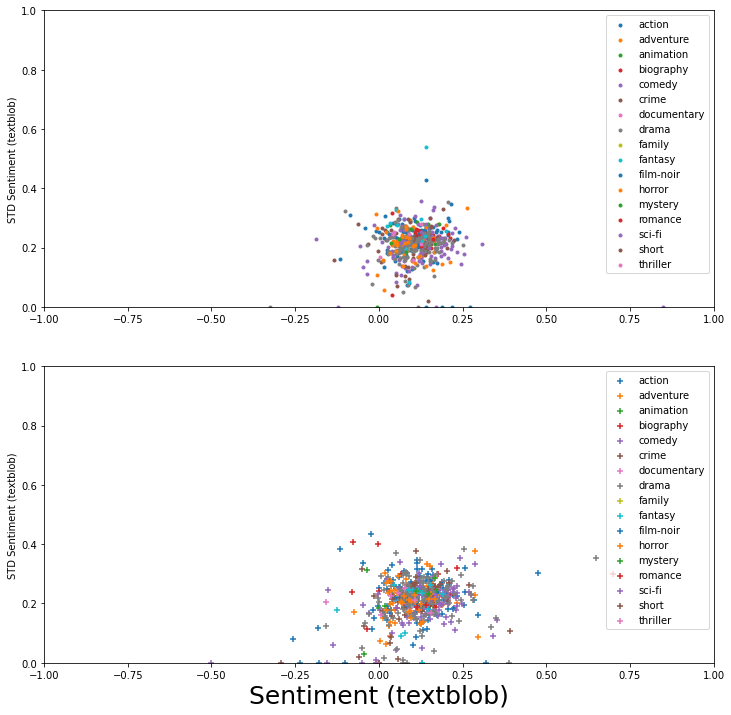

In [101]:
groups = info_df.groupby('genre')
fig, ax = plt.subplots(figsize=(12,12), nrows=2)

for name, group in groups:
    ax[0].scatter(group.male_sent_blob, group.std_male_sent_blob, label=name, marker='.')
    ax[1].scatter(group.female_sent_blob, group.std_female_sent_blob, label=name, marker='+')

ax[0].set_xlim([-1, 1])
ax[0].set_ylim([0, 1])
ax[1].set_xlim([-1, 1])
ax[1].set_ylim([0, 1])
plt.xlabel('Sentiment (textblob)',fontsize=25)
# plt.ylabel('STD Subjectivity (textblob)',fontsize=25)
plt.setp(ax[:], ylabel='STD Sentiment (textblob)')

ax[0].legend(loc = 'upper right')
ax[1].legend(loc = 'upper right')

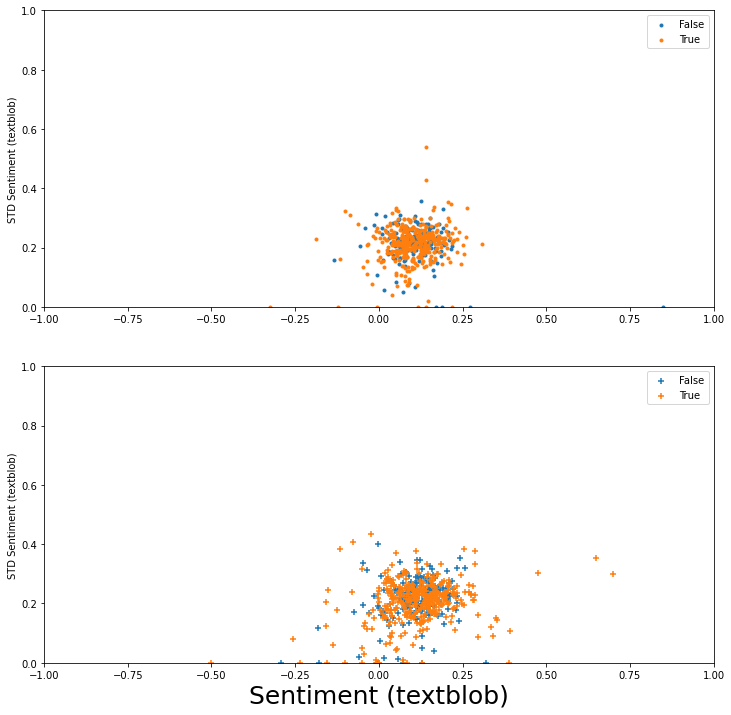

In [102]:
groups = info_df.groupby('female_prefer')
fig, ax = plt.subplots(figsize=(12,12), nrows=2)

for name, group in groups:
    ax[0].scatter(group.male_sent_blob, group.std_male_sent_blob, label=name, marker='.',)
    ax[1].scatter(group.female_sent_blob, group.std_female_sent_blob, label=name, marker='+')

ax[0].set_xlim([-1, 1])
ax[0].set_ylim([0, 1])
ax[1].set_xlim([-1, 1])
ax[1].set_ylim([0, 1])
plt.xlabel('Sentiment (textblob)',fontsize=25)
# plt.ylabel('STD Subjectivity (textblob)',fontsize=25)
plt.setp(ax[:], ylabel='STD Sentiment (textblob)')

ax[0].legend(loc = 'upper right')
ax[1].legend(loc = 'upper right')

[Text(0, 0.5, 'STD Sentiment (textblob)'),
 Text(0, 0.5, 'STD Sentiment (textblob)')]

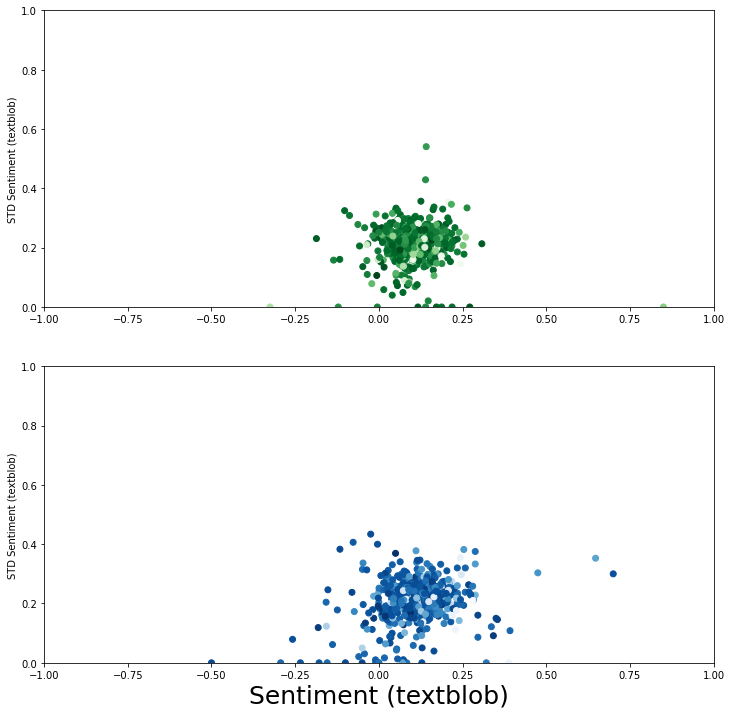

In [103]:
fig, ax = plt.subplots(figsize=(12,12), nrows=2)

ax[0].scatter(info_df['male_sent_blob'], info_df['std_male_sent_blob'], c=info_df['year'], cmap='Greens')
ax[1].scatter(info_df['female_sent_blob'], info_df['std_female_sent_blob'], c=info_df['year'], cmap='Blues')

ax[0].set_xlim([-1, 1])
ax[0].set_ylim([0, 1])
ax[1].set_xlim([-1, 1])
ax[1].set_ylim([0, 1])
plt.xlabel('Sentiment (textblob)',fontsize=25)
# plt.ylabel('STD Subjectivity (textblob)',fontsize=25)
plt.setp(ax[:], ylabel='STD Sentiment (textblob)')

### Subjectivity textblob

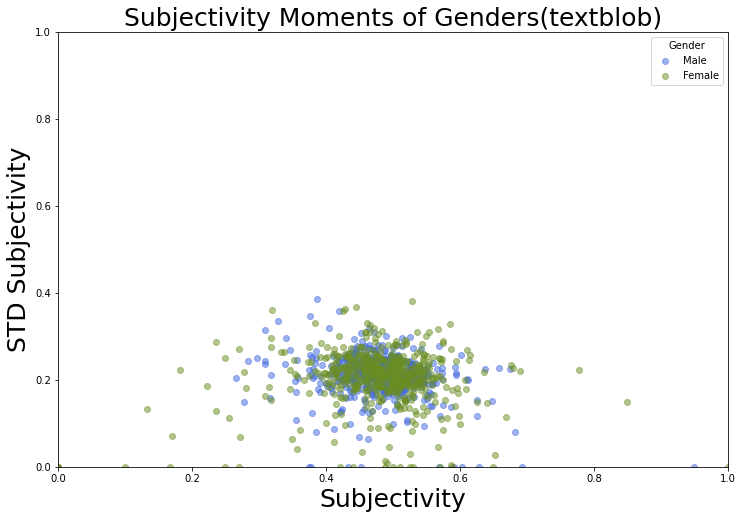

In [185]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(info_df['male_subj_blob'], info_df['std_male_subj_blob'], c='royalblue', label='Male', alpha=0.5)
ax.scatter(info_df['female_subj_blob'], info_df['std_female_subj_blob'], c='olivedrab', label='Female', alpha=0.5)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Subjectivity',fontsize=25)
plt.ylabel('STD Subjectivity',fontsize=25)
plt.legend(loc = 'upper right', title='Gender')
plt.title('Subjectivity Moments of Genders(textblob)', fontsize=25)
plt.savefig('/content/drive/MyDrive/IMDB/fig_results/mean_std/subj_blob.png')

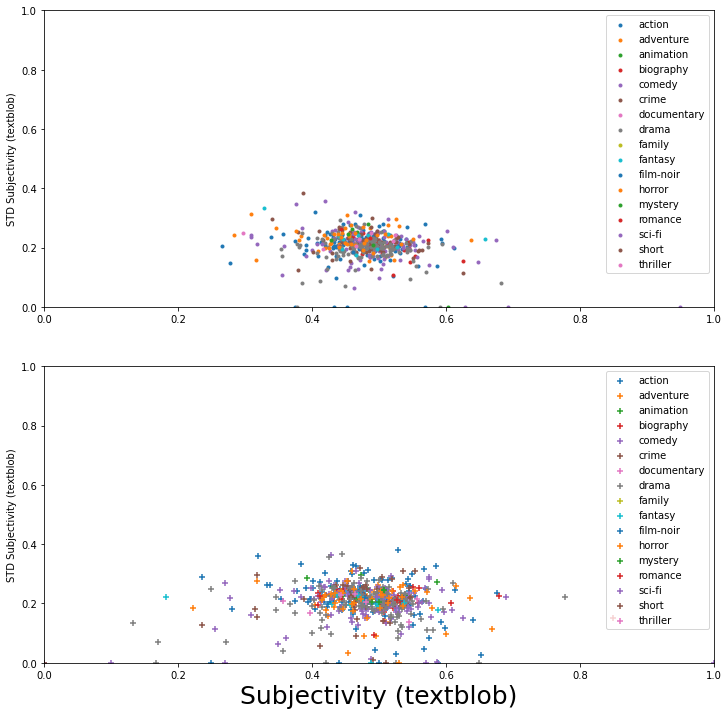

In [105]:
groups = info_df.groupby('genre')
fig, ax = plt.subplots(figsize=(12,12), nrows = 2)

for name, group in groups:
    ax[0].scatter(group.male_subj_blob, group.std_male_subj_blob, label=name, marker='.')
    ax[1].scatter(group.female_subj_blob, group.std_female_subj_blob, label=name, marker='+')

ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])
plt.xlabel('Subjectivity (textblob)',fontsize=25)
# plt.ylabel('STD Subjectivity (textblob)',fontsize=25)
plt.setp(ax[:], ylabel='STD Subjectivity (textblob)')

ax[0].legend(loc = 'upper right')
ax[1].legend(loc = 'upper right')

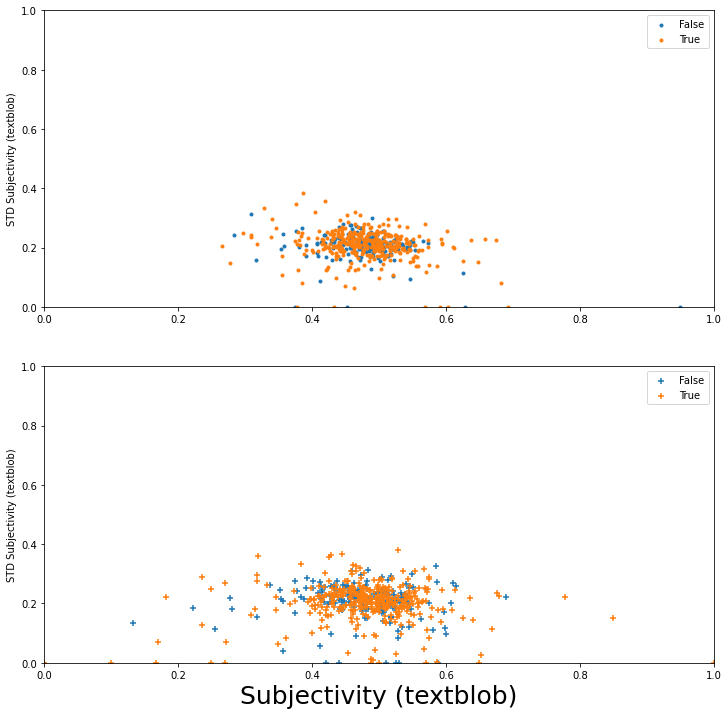

In [106]:
groups = info_df.groupby('female_prefer')
fig, ax = plt.subplots(figsize=(12,12), nrows=2)

for name, group in groups:
    ax[0].scatter(group.male_subj_blob, group.std_male_subj_blob, label=name, marker='.',)
    ax[1].scatter(group.female_subj_blob, group.std_female_subj_blob, label=name, marker='+')

ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])
plt.xlabel('Subjectivity (textblob)',fontsize=25)
# plt.ylabel('STD Subjectivity (textblob)',fontsize=25)
plt.setp(ax[:], ylabel='STD Subjectivity (textblob)')


ax[0].legend(loc = 'upper right')
ax[1].legend(loc = 'upper right')

[Text(0, 0.5, 'STD Subjectivity (textblob)'),
 Text(0, 0.5, 'STD Subjectivity (textblob)')]

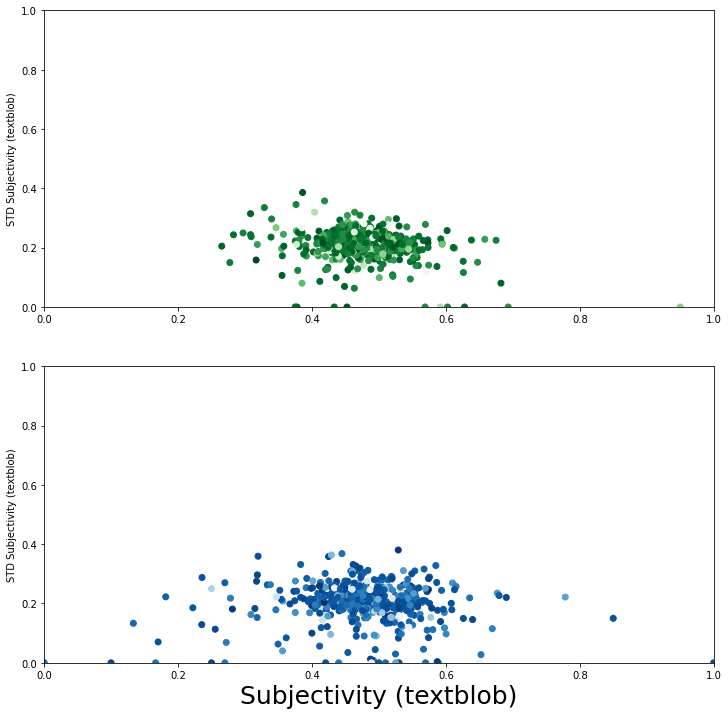

In [107]:
fig, ax = plt.subplots(figsize=(12,12), nrows=2)

ax[0].scatter(info_df['male_subj_blob'], info_df['std_male_subj_blob'], c=info_df['year'], cmap='Greens')
ax[1].scatter(info_df['female_subj_blob'], info_df['std_female_subj_blob'], c=info_df['year'], cmap='Blues')

ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])
plt.xlabel('Subjectivity (textblob)',fontsize=25)
# plt.ylabel('STD Subjectivity (textblob)',fontsize=25)
plt.setp(ax[:], ylabel='STD Subjectivity (textblob)')


### Sentiment IMDB50k

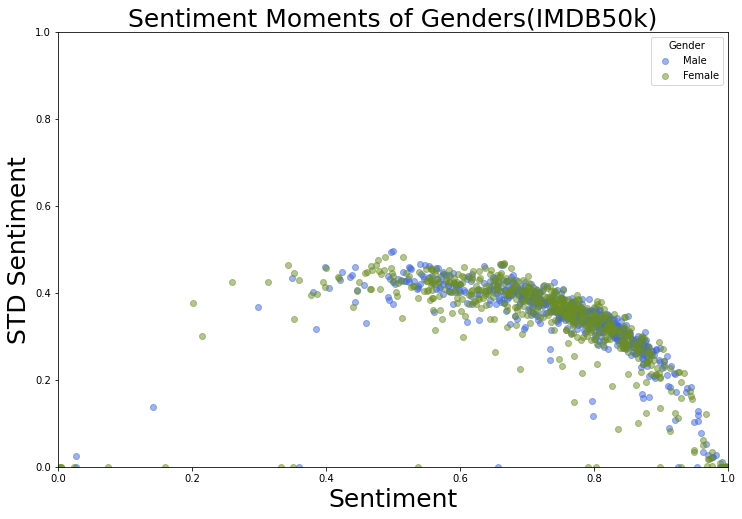

In [186]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(info_df['male_sent_self'], info_df['std_male_sent_self'], c='royalblue', label='Male', alpha=0.5)
ax.scatter(info_df['female_sent_self'], info_df['std_female_sent_self'], c='olivedrab', label='Female', alpha=0.5)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Sentiment',fontsize=25)
plt.ylabel('STD Sentiment',fontsize=25)
plt.legend(loc = 'upper right', title='Gender')
plt.title('Sentiment Moments of Genders(IMDB50k)', fontsize=25)
plt.savefig('/content/drive/MyDrive/IMDB/fig_results/mean_std/senti_IMDB50k.png')

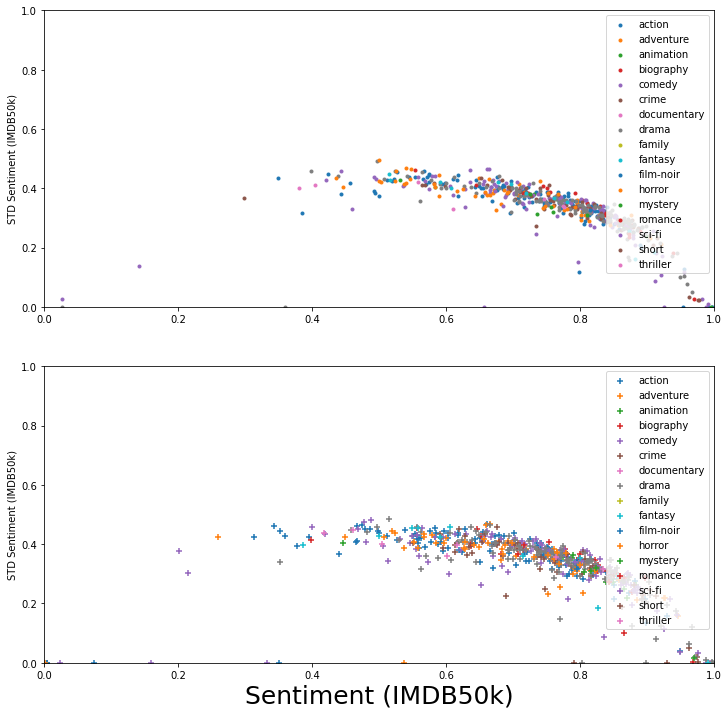

In [109]:
groups = info_df.groupby('genre')
fig, ax = plt.subplots(figsize=(12,12), nrows=2)

for name, group in groups:
    ax[0].scatter(group.male_sent_self, group.std_male_sent_self, label=name, marker='.')
    ax[1].scatter(group.female_sent_self, group.std_female_sent_self, label=name, marker='+')

ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])
plt.xlabel('Sentiment (IMDB50k)',fontsize=25)
# plt.ylabel('STD Sentiment (IMDB50k)',fontsize=25)
plt.setp(ax[:], ylabel='STD Sentiment (IMDB50k)')

ax[0].legend(loc = 'upper right')
ax[1].legend(loc = 'upper right')

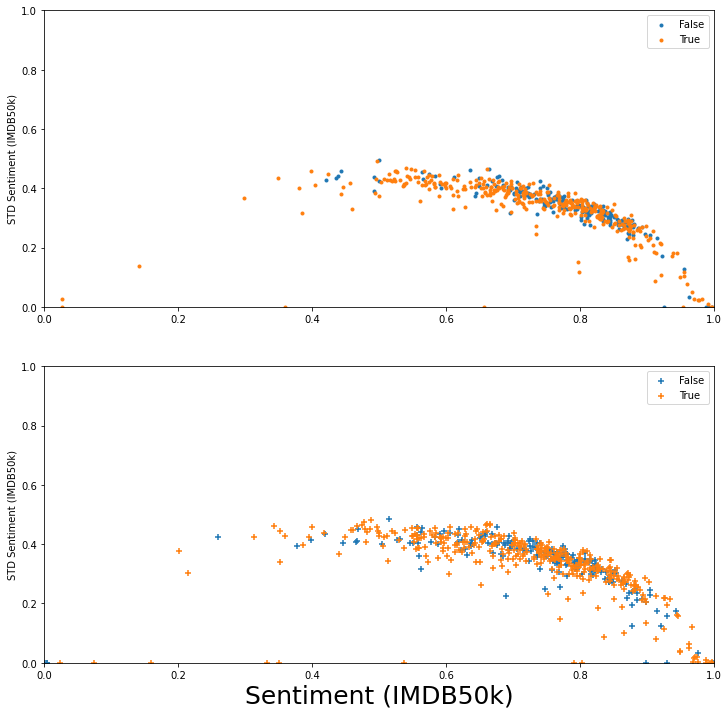

In [110]:
groups = info_df.groupby('female_prefer')
fig, ax = plt.subplots(figsize=(12,12), nrows=2)

for name, group in groups:
    ax[0].scatter(group.male_sent_self, group.std_male_sent_self, label=name, marker='.')
    ax[1].scatter(group.female_sent_self, group.std_female_sent_self, label=name, marker='+')

ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])
plt.xlabel('Sentiment (IMDB50k)',fontsize=25)
# plt.ylabel('STD Sentiment (IMDB50k)',fontsize=25)
plt.setp(ax[:], ylabel='STD Sentiment (IMDB50k)')

ax[0].legend(loc = 'upper right')
ax[1].legend(loc = 'upper right')

[Text(0, 0.5, 'STD Sentiment (IMDB50k)'),
 Text(0, 0.5, 'STD Sentiment (IMDB50k)')]

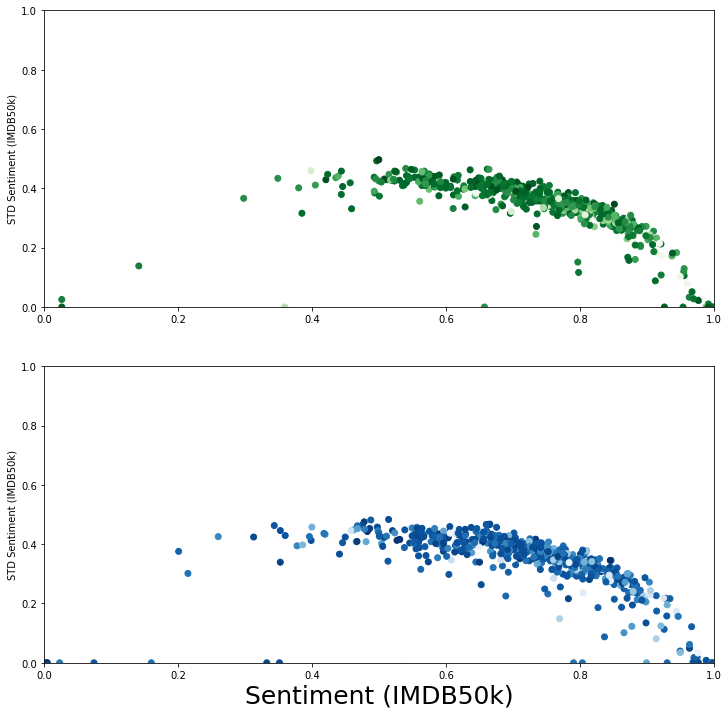

In [111]:
fig, ax = plt.subplots(figsize=(12,12), nrows=2)

ax[0].scatter(info_df['male_sent_self'], info_df['std_male_sent_self'], c=info_df['year'], cmap='Greens')
ax[1].scatter(info_df['female_sent_self'], info_df['std_female_sent_self'], c=info_df['year'], cmap='Blues')

ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])
plt.xlabel('Sentiment (IMDB50k)',fontsize=25)
# plt.ylabel('STD Sentiment (IMDB50k)',fontsize=25)
plt.setp(ax[:], ylabel='STD Sentiment (IMDB50k)')

# Time-based Sentiments

## Raw Data

In [4]:
import glob
sentiment_paths = glob.glob('/content/drive/MyDrive/IMDB/sentiment_year/*')
print("Number of movies having review with character-related parts:", len(sentiment_paths))

Number of movies having review with character-related parts: 25


In [5]:
data = {}
for path in sentiment_paths:
  year = path.split('/')[-1].split('.')[0]
  with open(path) as f:
    data[year] = json.load(f)

In [7]:
sent_elements = set(data['2002']['tt0118564'])
sent_elements

{'female_revw_blob',
 'female_revw_self',
 'female_revw_subj',
 'male_revw_blob',
 'male_revw_self',
 'male_revw_subj'}

In [8]:
for year in data:
  for movie in data[year]:
    if len(data[year][movie].keys()) < 6:
      fills = sent_elements - set(data[year][movie].keys())
      for fill in fills:
        data[year][movie][fill] = []

In [28]:
data_temp = {key:{} for key in sent_elements}
for year in data:
  for key in sent_elements:
    data_temp[key][year] = {}

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
for year in data:
  for movie in data[year]:
    for ele in data[year][movie]:
      data_temp[ele][year][movie] = np.nanmean(data[year][movie][ele])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [34]:
data_for_vis = {key:{} for key in sent_elements}

In [37]:
for ele in sent_elements:
  for year in data:
    data_for_vis[ele][year] = np.nanmean(list(data_temp[ele][year].values()))

In [45]:
df_time = pd.DataFrame.from_dict(data_for_vis).sort_index()
df_time

,male_revw_blob,female_revw_blob,male_revw_subj,female_revw_self,male_revw_self,female_revw_subj
1998,0.147904,0.167512,0.482569,0.695173,0.807235,0.498426
1999,0.117560,0.139759,0.484911,0.752011,0.730424,0.510904
2000,0.122244,0.129136,0.499562,0.726341,0.758264,0.495788
2001,0.114742,0.135036,0.474224,0.746405,0.753824,0.491938
2002,0.122643,0.142044,0.471711,0.735090,0.747778,0.484131
2003,0.119762,0.121879,0.476348,0.714711,0.755451,0.478077
2004,0.107805,0.114389,0.488729,0.735901,0.730134,0.494256
2005,0.108664,0.110082,0.480756,0.736527,0.765043,0.477957
2006,0.115243,0.116451,0.484336,0.775600,0.769821,0.483516
2007,0.108043,0.124773,0.490725,0.763613,0.783382,0.487658


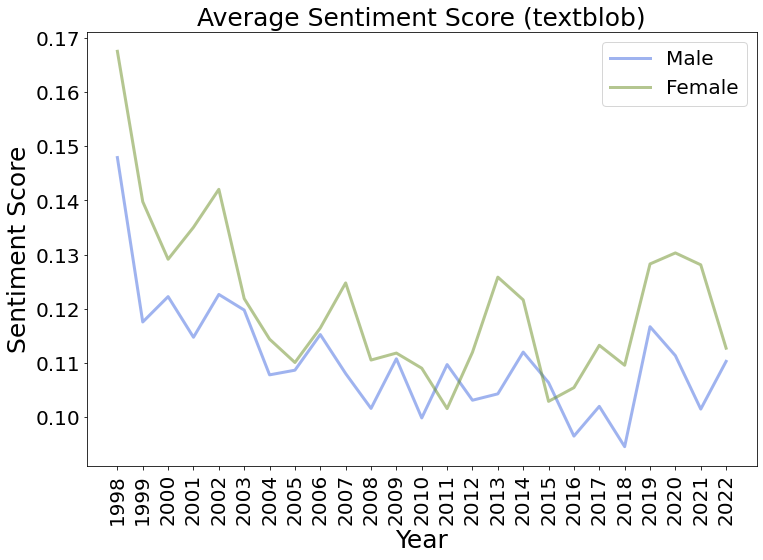

In [62]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df_time.male_revw_blob, c='royalblue', linewidth=3, alpha=0.5, label = 'Male')
ax.plot(df_time.female_revw_blob, c='olivedrab', linewidth=3, alpha=0.5, label = 'Female')
plt.title("Average Sentiment Score (textblob)",fontsize=25)
plt.ylabel('Sentiment Score',fontsize=25)
# plt.ylim([0, 0.2])
plt.xlabel('Year',fontsize=25)
plt.xticks(fontsize=20, rotation=90);
plt.yticks(fontsize=20);
plt.legend(loc = 'upper right',fontsize=20)
plt.savefig('/content/drive/MyDrive/IMDB/fig_results/sentiment_blob_time.png')

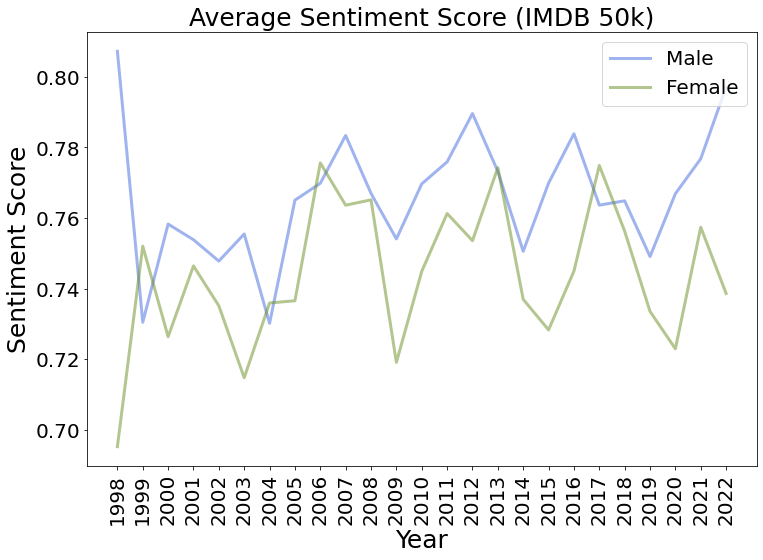

In [63]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df_time.male_revw_self, c='royalblue', linewidth=3, alpha=0.5, label = 'Male')
ax.plot(df_time.female_revw_self, c='olivedrab', linewidth=3, alpha=0.5, label = 'Female')
plt.title("Average Sentiment Score (IMDB 50k)",fontsize=25)
plt.ylabel('Sentiment Score',fontsize=25)
# plt.ylim([0, 1])
plt.xlabel('Year',fontsize=25)
plt.xticks(fontsize=20, rotation=90);
plt.yticks(fontsize=20);
plt.legend(loc = 'upper right',fontsize=20)
plt.savefig('/content/drive/MyDrive/IMDB/fig_results/sentiment_self_time.png')

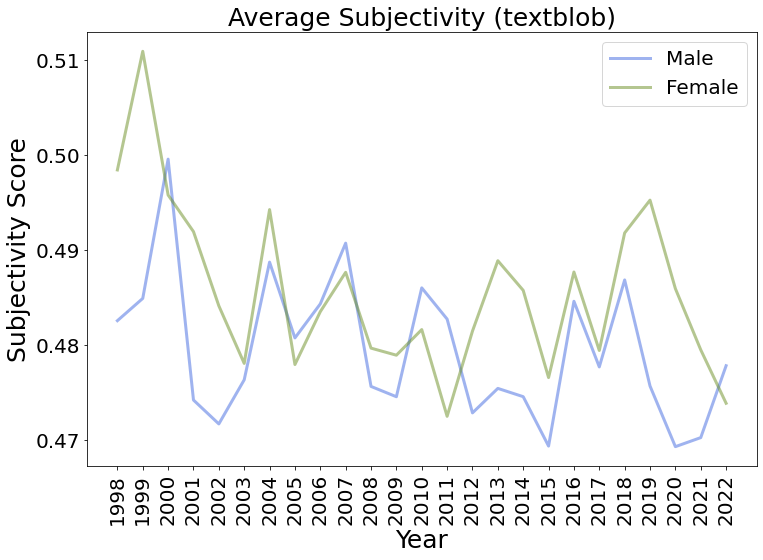

In [64]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df_time.male_revw_subj, c='royalblue', linewidth=3, alpha=0.5, label = 'Male')
ax.plot(df_time.female_revw_subj, c='olivedrab', linewidth=3, alpha=0.5, label = 'Female')
plt.title("Average Subjectivity (textblob)",fontsize=25)
plt.ylabel('Subjectivity Score',fontsize=25)
# plt.ylim([0, 1])
plt.xlabel('Year',fontsize=25)
plt.xticks(fontsize=20, rotation=90);
plt.yticks(fontsize=20);
plt.legend(loc = 'upper right',fontsize=20)
plt.savefig('/content/drive/MyDrive/IMDB/fig_results/subjectivity_blob_time.png')